#UFO DATA EXPLORATION

In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%%time
#raw_data = pd.read_csv('./data/complete.csv')
scrubbed_data = pd.read_csv('../raw_data/scrubbed.csv', low_memory=False)

CPU times: user 240 ms, sys: 41 ms, total: 281 ms
Wall time: 347 ms


In [3]:
scrubbed_data.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [4]:
import seaborn as sns
plt.style.use('dark_background')
plt.rcParams['font.size'] = 14
plt.figure(figsize=(12,5))
palette = sns.color_palette('Paired', 10)

<Figure size 864x360 with 0 Axes>

In [3]:
scrubbed_data['country'].describe()
scrubbed_data['city'].describe()

count       80332
unique      19900
top       seattle
freq          525
Name: city, dtype: object

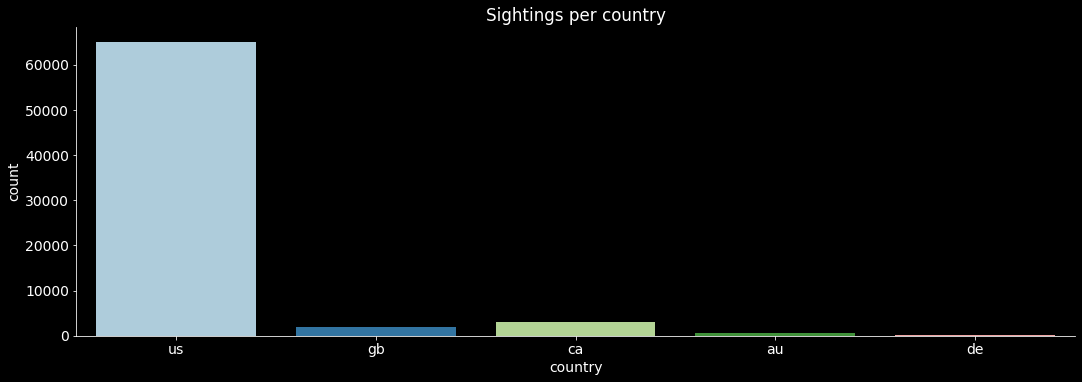

In [6]:
sns.catplot(x="country", kind="count", palette=palette, data=scrubbed_data, height=5, aspect=3);
sns.despine()
plt.title('Sightings per country');
plt.show()

In [7]:
def extract_time_features(df):
    timezone_name = 'America/New_York'
    time_column = "datetime"
    df['datetime_zero'] = df[time_column].str.replace('24:00', '0:00')
    df['datetime_er'] = pd.to_datetime(df['datetime_zero'], format='%m/%d/%Y %H:%M')
    selrow = df['datetime'].str.contains('24:00')
    df[time_column] = df['datetime_er'] + selrow * timedelta(days=1)
    df.index = pd.to_datetime(df[time_column])
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)

In [8]:
time_df = extract_time_features(scrubbed_data)

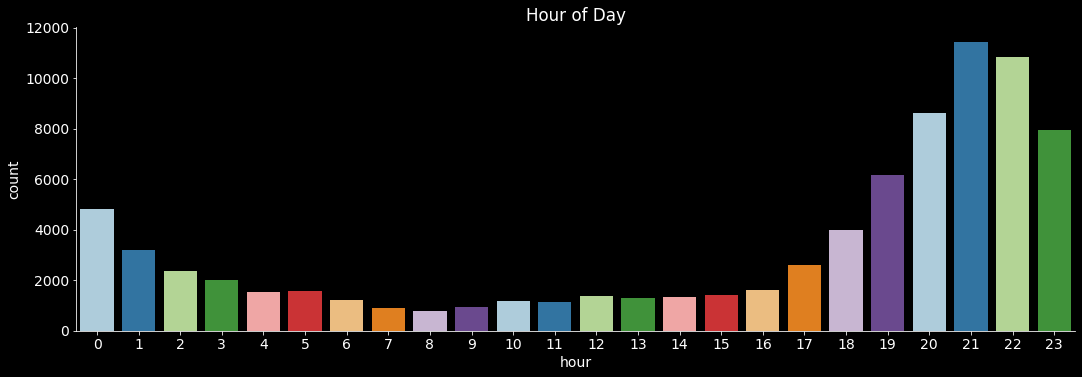

In [9]:
sns.catplot(x="hour", kind="count", palette=palette, data=time_df, height=5, aspect=3);
sns.despine()
plt.title('Hour of Day');
plt.show()

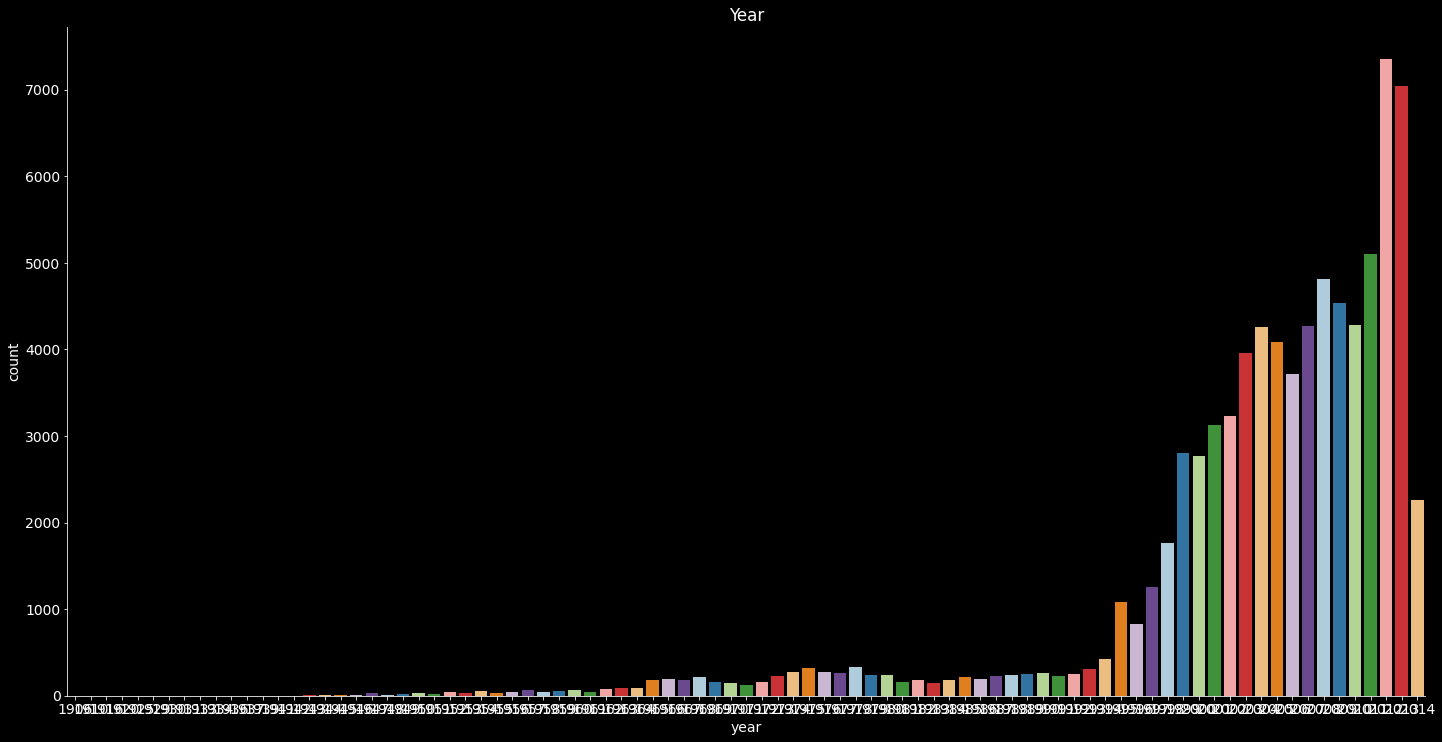

In [10]:
sns.catplot(x="year", kind="count", palette=palette, data=time_df, height=10, aspect=2);
sns.despine()
plt.title('Year');
plt.show()

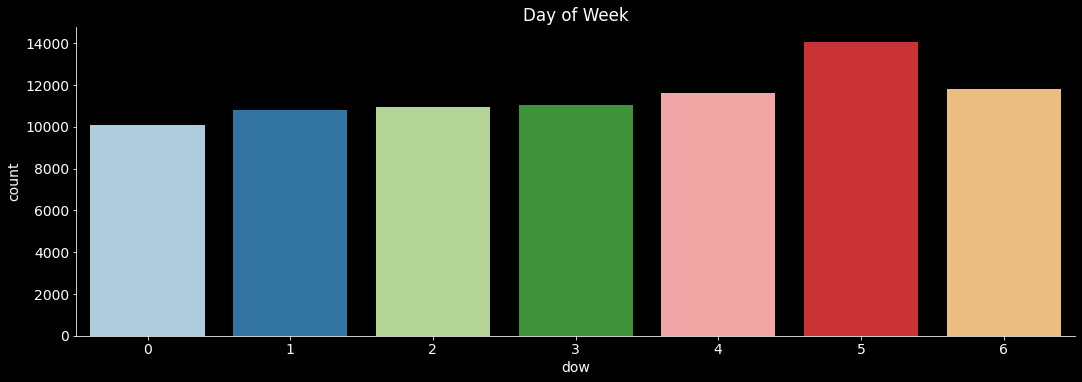

In [11]:
sns.catplot(x="dow", kind="count", palette=palette, data=time_df, height=5, aspect=3);
sns.despine()
plt.title('Day of Week');
plt.show()

In [12]:
!pip install folium
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

You should consider upgrading via the '/Users/juan/.pyenv/versions/3.8.6/envs/alien/bin/python3.8 -m pip install --upgrade pip' command.


In [13]:
center_location = 29.8830556, -97.9411111
m = folium.Map(location=center_location, control_scale=True, zoom_start=3)

In [14]:
location_df = scrubbed_data[['latitude',
                             'longitude ']]

In [15]:
location_df['count'] = 1
heatmap_data = location_df.head(10000).groupby(['latitude', 'longitude ']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

<ipython-input-15-79c7aafa0fac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df['count'] = 1


In [16]:
time_df['count'] = 1
heatmap_data_by_hour = []
__df__ = time_df.head(10000)
for hour in time_df.hour.sort_values().unique():
    _df = __df__[__df__.hour == hour][['longitude ', 'latitude', 'count']].groupby(['latitude', 'longitude ']).sum().reset_index().values.tolist()
    heatmap_data_by_hour.append(_df)

In [17]:
m2 = folium.Map(location=center_location, control_scale=True, zoom_start=11)
HeatMapWithTime(heatmap_data_by_hour, radius=5, 
                gradient=gradient, 
                min_opacity=0.5, max_opacity=0.8, 
                use_local_extrema=False).add_to(m2)
m2

In [18]:
new_data = pd.read_csv('../raw_data/ufo.csv')

In [19]:
new_data.head()

,Datetime,City,State,Shape,Duration,Summary,Posted
0,4/23/21 06:30,Blackshear,GA,Circle,9 minutes,Very strange ((NUFORC Note: Rocket launch f...,4/23/21
1,4/23/21 06:00,Mechanicsville,VA,Circle,Seconds,Ball in the sky ((NUFORC Note: Rocket launc...,4/23/21
2,4/23/21 06:00,Vero Beach,FL,Light,5 minutes,I was driving and saw something strange in the...,4/23/21
3,4/23/21 05:59,St. Augustine,FL,Light,3 minutes,2 extremely bright lights appeared over east c...,4/23/21
4,4/23/21 05:58,Durham,NC,Cone,>5 minutes,A cone of light coming from the sky unlike any...,4/23/21


In [20]:
print(len(new_data))
new_data = new_data.drop_duplicates()
len(new_data)

97250


97154

In [21]:
print(len(new_data))
new_data = new_data.dropna()
len(new_data)

97154


86220

In [22]:
new_data['Datetime'] = pd.to_datetime(new_data['Datetime'], errors='coerce')
new_data.dtypes

Datetime    datetime64[ns]
City                object
State               object
Shape               object
Duration            object
Summary             object
Posted              object
dtype: object

In [23]:
latest_date = scrubbed_data['datetime'].max()
latest_date

Timestamp('2014-05-08 18:45:00')

In [24]:
new_data = new_data[new_data['Datetime'] > latest_date]
len(new_data)

38272

In [25]:
new_data.min()

Datetime                                  2014-05-08 19:20:00
City                      ((Location no revealed by witness))
State                                                      AB
Shape                                                Changing
Duration                                           15 minutes
Summary     \t\tI looked out my back door that faces N, I ...
Posted                                                1/10/09
dtype: object

In [26]:
new_data['full_address'] = new_data.City + ',' + new_data.State

In [27]:
from geopy.geocoders import Nominatim

In [28]:
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")

def geocode_my_address(addr):
  # function that won't crash if it runs into a bad address
  print('geocoding:', addr)
  try:
    x = geolocator.geocode(addr)
    lat_lng = x.latitude, x.longitude
    return lat_lng
  except:
    print("problem with address:", addr)
    lat_lng = None, None
    return lat_lng


In [29]:
new_data['latitude'], new_data['longitude'] = zip(*new_data['full_address'].apply(lambda x: geocode_my_address(x)))


geocoding: Blackshear,GA
geocoding: Mechanicsville,VA
geocoding: Vero Beach,FL
geocoding: St. Augustine,FL
geocoding: Durham,NC
geocoding: I-16 south,GA
geocoding: Parrish,FL
geocoding: Champions Gate,FL
geocoding: Belleview,FL
geocoding: Firestone,CO
geocoding: New York City (Brooklyn),NY
geocoding: Appleton,WI
geocoding: Dallas,GA
geocoding: Oregon City,OR
geocoding: Eatonton,GA
geocoding: Woodbridge,NJ
geocoding: Payson,AZ
geocoding: Brier,WA
geocoding: Bridgton,ME
geocoding: Minneapolis,MN
geocoding: Hartford,CT
geocoding: Dublin,PA
geocoding: New York City (Brooklyn),NY
geocoding: San Mateo,CA
geocoding: Glen Oaks,NY
geocoding: Tulare,CA
geocoding: Marietta,GA
geocoding: Clarion,PA
geocoding: Lafayette,CO
geocoding: Spanish Valley,UT
geocoding: Nanaimo (Canada),BC
geocoding: Riverdale,UT
geocoding: Hollywood,FL
geocoding: Independence,KS
geocoding: Indianapolis,IN
geocoding: Valdosta,GA
geocoding: Church Hill,TN
geocoding: Porter,OK
geocoding: Kent,WA
geocoding: Port Washington,WI

problem with address: Pass a grill Beach,FL
geocoding: West Richland,WA
geocoding: Kennewick,WA
geocoding: Danvers,MA
geocoding: Santa Ana,CA
geocoding: Sacramento,CA
geocoding: Riverdale,MI
geocoding: Shakopee,MN
geocoding: Bennington,KS
geocoding: Tucson,AZ
geocoding: Tucson,AZ
geocoding: Pinkney,MI
geocoding: Pittsburgh,PA
geocoding: Guilderland,NY
geocoding: Denver,NC
geocoding: Willard,OH
geocoding: Butler,PA
geocoding: Richmond,VA
geocoding: Nampa,ID
geocoding: Roaring river,NC
geocoding: Maysville,OK
geocoding: Lansdowne,PA
geocoding: Marietta,GA
geocoding: Pryor,OK
geocoding: Brewerton,NY
geocoding: Willowbrook,IL
geocoding: Cave Creek,AZ
geocoding: Wiarton (Canada),ON
geocoding: Jamestown,CA
geocoding: Voleny,NY
problem with address: Voleny,NY
geocoding: Normal,IL
geocoding: Porterville,CA
geocoding: Redding,CA
geocoding: Denver,CO
geocoding: Austin,TX
geocoding: Mojave,CA
geocoding: North of Holbrook,AZ
geocoding: Newport,RI
geocoding: Oxnard,CA
geocoding: Oxford,PA
geocoding

geocoding: Lincoln,NE
geocoding: Philadelphia,PA
geocoding: Reading,PA
geocoding: Reading,PA
geocoding: Brooklyn, NY,NY
geocoding: Colburn,ID
geocoding: Richmondville,NY
geocoding: Commerce,GA
geocoding: La Mesa,CA
geocoding: Medina,OH
geocoding: Lancaster,MA
geocoding: Sydney,NS
geocoding: Bloomingdale,IL
geocoding: Harrison,MI
geocoding: Albuquerque,NM
geocoding: Athelstane,WI
geocoding: Afton,IA
geocoding: Tustin,CA
geocoding: Saint Peters,MO
geocoding: Springfield,OR
geocoding: Modesto,CA
geocoding: North Zulch,TX
geocoding: Painesville,OH
geocoding: Topeka,KS
geocoding: Fuera Bush/Delmar,NY
problem with address: Fuera Bush/Delmar,NY
geocoding: Marietta,OH
geocoding: Wichita,KS
geocoding: Mount vernon,WA
geocoding: Northampton,MA
geocoding: Warminster,PA
geocoding: Feasterville,PA
geocoding: Pylesville,MD
geocoding: Hatfield,PA
geocoding: Wells,ME
geocoding: Lakeland,FL
geocoding: Stillwater,NY
geocoding: Naugatuck,CT
geocoding: Phoenix,AZ
geocoding: Bristol,CT
geocoding: Bristol,C

geocoding: Riverton,WY
geocoding: Pacific City,OR
geocoding: Iowa City,IA
geocoding: Grants Pass,OR
geocoding: Valentine,NE
geocoding: Blair,NE
geocoding: Mc Henry,IL
geocoding: Alfred,ME
geocoding: South whitley,IN
geocoding: Boulder,CO
geocoding: Longmont,CO
geocoding: Lafayette,CO
geocoding: Evergreen,CO
geocoding: Vacaville,CA
geocoding: Nashville,TN
geocoding: Granite City,IL
geocoding: Laramie,WY
geocoding: Santa Fe,NM
geocoding: Brookfield,IL
geocoding: Poplar Bluff,MO
geocoding: Englewood,CO
geocoding: Verona,WI
geocoding: Pueblo,CO
geocoding: Urbandale,IA
geocoding: Ft.atkinson,IA
geocoding: Boise,ID
geocoding: Columbus,OH
geocoding: Gilbert,AZ
geocoding: Hilliard,OH
geocoding: Fort Bragg,NC
geocoding: Cottage grove,OR
geocoding: Kirksville,MO
geocoding: Amherst,MA
geocoding: Clifton,CO
geocoding: Laramie,WY
geocoding: Mountain Home,ID
geocoding: springfield,IL
geocoding: niwot,CO
geocoding: Phoenix,AZ
geocoding: Springfield,IL
geocoding: Hollister,CA
geocoding: Arroyo Grande,

geocoding: Esther,AK
geocoding: East Freedom,PA
geocoding: Shirleysburg,PA
geocoding: Millstadt,IL
geocoding: Irvine,KY
geocoding: Indianapolis,IN
geocoding: Pomona,NJ
geocoding: Kelly Crossroads,PA
geocoding: Stockton,CA
geocoding: New York,NY
geocoding: Clarksville,NY
geocoding: West Suffield,CT
geocoding: Centennial,CO
geocoding: Alexander,NC
geocoding: Hunter,NY
geocoding: Creede,CO
geocoding: Oakdale,PA
geocoding: Newington,CT
geocoding: Harrisburg,PA
geocoding: Needham,MA
geocoding: Canal Winchester,OH
geocoding: Kalamazoo,MI
geocoding: Huntington,WV
geocoding: Palacios,TX
geocoding: Dover,DE
geocoding: Fulton,NY
geocoding: Kirkland,QC
geocoding: Visalia,CA
geocoding: Portland,OR
geocoding: Evans,CO
geocoding: Houston,TX
geocoding: Plattekill,NY
geocoding: Southaven,MS
geocoding: Essex,MD
geocoding: Essex,MD
geocoding: Arlington,VA
geocoding: Columbia,AL
geocoding: Lower Moreland,PA
geocoding: Grimsby (Canada),ON
geocoding: Oklahoma City,OK
geocoding: Rochester,NH
geocoding: Manc

geocoding: North Ft. Myers,FL
geocoding: Alexandris,LA
geocoding: Pittsburgh,PA
geocoding: Palmdale,CA
geocoding: Monroe,WA
geocoding: Elizabethton,TN
geocoding: Kings Mountain,NC
geocoding: Cary,NC
geocoding: Metairie,LA
geocoding: SW Portland,OR
geocoding: Spokane,WA
geocoding: Philomath,OR
geocoding: Yakima,WA
geocoding: Nanaimo (Canada),BC
geocoding: Mt. Angel,OR
geocoding: mountain grove,MO
geocoding: Encinitas,CA
geocoding: Scarborough (Canada),ON
geocoding: Glace Bay (Canada),NS
geocoding: Harlansburg,PA
geocoding: Knoxville,TN
geocoding: robertsdale,AL
geocoding: Russellville,AR
geocoding: San Antonio,TX
geocoding: Cape Coral,FL
geocoding: Port Crane,NY
geocoding: Junction City,CA
geocoding: Battle Creek,MI
geocoding: Bloomington,IL
geocoding: Evaro,MT
geocoding: S. Burlington,VT
geocoding: Missoula,MT
geocoding: Dover,FL
geocoding: Colorado Springs,CO
geocoding: Tucson,AZ
geocoding: Pepin,WI
geocoding: Center Conway,NH
geocoding: Wellington (Canada),ON
geocoding: Lancaster,CA


geocoding: Vernon Hills,IL
geocoding: Port Saint Lucie,FL
geocoding: Cherry Hill,NJ
geocoding: Linden,VA
geocoding: Long Island,NY
geocoding: Depoe Bay,OR
geocoding: Depoe Bay,OR
geocoding: Depoe Bay,OR
geocoding: Dartmouth,MA
geocoding: Valley grove,WV
geocoding: San Diego,CA
geocoding: Columbus,OH
geocoding: Fort Albany (Canada),ON
geocoding: Vancouver (Canada),BC
geocoding: Virginia Beach,VA
geocoding: Post Falls,ID
geocoding: Rossville,KS
geocoding: Middlefield,OH
geocoding: Everett,WA
geocoding: Sparta,NC
geocoding: Alberta (rural)(Canada),AB
geocoding: Riverton,WY
geocoding: Garrison,NY
geocoding: Joppa,MD
geocoding: Swoyersville,PA
geocoding: Broad Brook,CT
geocoding: Manchester/Hooksett,NH
geocoding: Menifee,CA
geocoding: Overland Park,KS
geocoding: Blackwell,PA
geocoding: Plant City,FL
geocoding: Taylors Falls,MN
geocoding: Elkhart,IN
geocoding: St. Clair,MI
geocoding: Troy,NY
geocoding: Forked River,NJ
geocoding: Lacey,WA
geocoding: Pompano Beach,FL
geocoding: Grafton,WI
geoc

geocoding: North Palm Beach,FL
geocoding: Hamilton (Canada),ON
geocoding: Payson,IL
geocoding: Orangeville,ON
geocoding: Maple Hts,OH
geocoding: New York City (Brooklyn),NY
geocoding: Austin,TX
geocoding: Welland (Canada),ON
geocoding: Mesa,AZ
geocoding: Westerly,RI
geocoding: Choctaw,OK
geocoding: Eagle Mountain,UT
geocoding: Dandridge,TN
geocoding: Pittsburg,MO
geocoding: Sullivan,MO
geocoding: Saskatoon,SK
geocoding: Ocean Springs,MS
geocoding: Sioux Falls,SD
geocoding: McKenna,WA
geocoding: Rockport,MA
geocoding: Amelia,OH
geocoding: San Antonio,TX
geocoding: St. Paul,MN
geocoding: Marlton,NJ
geocoding: Sedalia,MO
geocoding: Bel Air,MD
geocoding: Hilliard,OH
geocoding: North Myrtle Beach,SC
geocoding: Marysville,OH
geocoding: Long Beach Island,NJ
geocoding: Phillipsburg,NJ
geocoding: Riverside,CA
geocoding: Dalmatia,PA
geocoding: Edmonton (Canada),AB
geocoding: Winnipegosis (Canada),MB
geocoding: Indialantic,FL
geocoding: Indianapolis,IN
geocoding: Ashland,OH
geocoding: Colorado Sp

geocoding: Lansing,MI
geocoding: Lansing,MI
geocoding: Au Train (Forest Lake),MI
geocoding: Renton,WA
geocoding: Rumford,ME
geocoding: Ogden,UT
geocoding: Filer,ID
geocoding: Pine Grove,PA
geocoding: West Valley City,UT
geocoding: Brampton (Canada),ON
geocoding: Garden City,SC
geocoding: Garden City,SC
geocoding: Austin,TX
geocoding: Keizer,OR
geocoding: Tucson,AZ
geocoding: Saint John,IN
geocoding: Labadie,MO
geocoding: North Las Vegas,NV
geocoding: Denver,CO
geocoding: Wildwood,MO
geocoding: Labadie,MO
geocoding: Boston,MA
geocoding: Fayetteville,GA
geocoding: Rougemont,NC
geocoding: Jackson,MI
geocoding: Toledo,OH
geocoding: Deer Park,TX
geocoding: Toccoa,GA
geocoding: Conway,SC
geocoding: Boiling Springs,PA
geocoding: Valley City,ND
geocoding: Hazleton,PA
geocoding: El Paso,TX
geocoding: Saskatoon (Canada),SK
geocoding: Lexington,NE
geocoding: Charlotte,NC
geocoding: Myrtle beach,SC
geocoding: Sundance Resort,UT
geocoding: North Myrtle Beach,SC
geocoding: Salt Lake City,UT
geocodin

geocoding: Portland,OR
geocoding: Portland,OR
geocoding: Malibu,CA
geocoding: Harrison,TN
geocoding: Downingtown,PA
geocoding: La Crosse,WI
geocoding: Altamont,NY
geocoding: Honolulu,HI
geocoding: Gibsonton,FL
geocoding: Brookings,SD
geocoding: Green county,KY
geocoding: Mableton,GA
geocoding: Portage,PA
geocoding: Vancouver Island (Canada),BC
geocoding: Glassboro,NJ
geocoding: Glassboro,NJ
geocoding: Lone Pine,CA
geocoding: Coeur d'Alene,ID
geocoding: Downingtown,PA
geocoding: Arlington,VT
geocoding: Austin,TX
geocoding: North Myrtle Beach,SC
geocoding: North Myrtle Beach,SC
geocoding: Merrick,NY
geocoding: Port Washington,NY
geocoding: Lancaster,CA
geocoding: Birmingham,AL
geocoding: North Myrtle Beach,SC
geocoding: Palm Desert,CA
geocoding: Lowell,MA
geocoding: Millcreek,WA
geocoding: Creedmoor,NC
geocoding: Quincy,MA
geocoding: South Beach,OR
geocoding: Lafayette,IN
geocoding: Shellsburg,IA
geocoding: Kitchener,ON
geocoding: Kent,WA
geocoding: Black Diamond,WA
geocoding: Balck Diam

geocoding: Mill Creek,WA
geocoding: Loraine,OH
geocoding: Kaministiquia (Canada),ON
geocoding: Dash Point,WA
geocoding: Richland,WA
geocoding: Deatsville,AL
geocoding: Granite Shoals,TX
geocoding: Oakland,CA
geocoding: Trenton,FL
geocoding: Annapolis,MD
geocoding: Sumner,WA
geocoding: Greenfield,MA
geocoding: Yorkville,NY
geocoding: Orlando,FL
geocoding: Mills,PA
geocoding: Morristown,TN
geocoding: Hillsborough,NJ
geocoding: Duluth,MN
geocoding: Hatteras,NC
geocoding: Between Sardinia and Winchester,OH
problem with address: Between Sardinia and Winchester,OH
geocoding: Pittsburgh,PA
geocoding: New York City (Manhattan),NY
geocoding: Cuyahoga Falls/Akron,OH
geocoding: West Abington Township,PA
geocoding: Portsmouth and Virginia Beach,VA
problem with address: Portsmouth and Virginia Beach,VA
geocoding: Bridgman,MI
geocoding: Owen Sound (Canada),ON
geocoding: Williamsburg,VA
geocoding: Allentown,PA
geocoding: Stevensville,MD
geocoding: Middletown,CT
geocoding: Moweaqua,IL
geocoding: Puyal

geocoding: Joshua Tree,CA
geocoding: New Orleans,LA
geocoding: Clinton,AR
geocoding: Garrison,NY
geocoding: Medford,OR
geocoding: Columbus,OH
geocoding: Derby,KS
geocoding: Edwardsville,IL
geocoding: Oklahoma City (SW OKC/ Moore,OK
problem with address: Oklahoma City (SW OKC/ Moore,OK
geocoding: Niagara Falls (Canada),ON
geocoding: Brookfield,CT
geocoding: Melford,KS
geocoding: Manchester,TN
geocoding: Hendrix,OK
geocoding: Folkston,GA
geocoding: Oro Valley,AZ
geocoding: Valley City,ND
geocoding: Apollo,PA
geocoding: Lummi Island,WA
geocoding: Inverness,FL
geocoding: Kimberly,ID
geocoding: Cherry Hill,NJ
geocoding: Austin,TX
geocoding: Amarillo,TX
geocoding: Portsmouth,VA
geocoding: Flemington,NJ
geocoding: Fairfax,VA
geocoding: Jonesboro,GA
geocoding: Marion,VA
geocoding: Pine Mountain,GA
geocoding: Salisbury,NC
geocoding: Lehigh Acres,FL
geocoding: Forsyth,GA
geocoding: Keysville,FL
geocoding: New York,NY
geocoding: Line Lexington,PA
geocoding: Weeki Wachee,FL
geocoding: Cincinnati,O

geocoding: Henrico,NC
geocoding: Kennewick,WA
geocoding: Joshua,TX
geocoding: Lake Keowee,SC
geocoding: Litchfield Park,AZ
geocoding: Citrus Springs,FL
geocoding: Nokomis,FL
geocoding: Fort Worth,TX
geocoding: Peoria,AZ
geocoding: Yuma,AZ
geocoding: East Amana,IA
geocoding: Plantation,FL
geocoding: Key Colony Beach,FL
geocoding: Lake Placid,FL
geocoding: Mattawa (Canada),ON
geocoding: Monrovia,MD
geocoding: Los Angeles,CA
geocoding: Bedford,NH
geocoding: Dutchtown,LA
geocoding: Persia,IA
geocoding: Kirkland,WA
geocoding: Fresno,CA
geocoding: Harrisonburg,VA
geocoding: Waynesboro,VA
geocoding: Kent,WA
geocoding: El Monte,CA
geocoding: San Rafael Swell,UT
problem with address: San Rafael Swell,UT
geocoding: Montrose,CO
geocoding: Greenville,SC
geocoding: Portland,OR
geocoding: Mokena,IL
geocoding: Forest Park,IL
geocoding: Glendale,AZ
geocoding: San Diego,CA
geocoding: Las Vegas,NV
geocoding: Colorado Springs,CO
geocoding: Powhatan,AR
geocoding: Missoula,MT
geocoding: Hilliard,FL
geocodi

geocoding: El Paso,TX
geocoding: Pompano Beach,FL
geocoding: Tulsa,OK
geocoding: Banning,CA
geocoding: Citrus Heights,CA
geocoding: Midland,TX
geocoding: Kelowna (Canada),BC
geocoding: Fort Jones,CA
geocoding: Fort Jones,CA
geocoding: Cape Coral,FL
geocoding: Geneva,FL
geocoding: Port Saint Lucie,FL
geocoding: Woodbury,GA
geocoding: Vero Beach,FL
geocoding: Los Angeles,CA
geocoding: Mount Pleasant,SC
geocoding: Ponte Vedra Beach,FL
geocoding: Birmingham,AL
geocoding: Richmond,TX
geocoding: Murfreesboro,TN
geocoding: Waynesboro,TN
geocoding: Melbourne,FL
geocoding: Holt,FL
geocoding: Tacoma,WA
geocoding: West Jordan,UT
geocoding: Covington,KY
geocoding: Frostproof,FL
geocoding: Carson City,NV
geocoding: Ewa Beach,HI
geocoding: Hammonton,NJ
geocoding: Trafalgar,IN
geocoding: Courtenay (Canada),BC
geocoding: Wilmington,NC
geocoding: Belton,SC
geocoding: Taylors,SC
geocoding: Millington,TN
geocoding: Iowa Park,TX
geocoding: Kamay,TX
geocoding: Iowa Park,TX
geocoding: Lawton,OK
geocoding: L

geocoding: St. Paul,MN
geocoding: Orleans,CA
geocoding: Duluth,MN
geocoding: Orem,UT
geocoding: Wahoo,NE
geocoding: Douglas,WY
geocoding: Bangor,MI
geocoding: Cassopolis,MI
geocoding: Salem,IL
geocoding: Duluth,MN
geocoding: Cedar Rapids,IA
geocoding: Eastport,MI
geocoding: Santa Rosa,CA
geocoding: Bracebridge (Canada),ON
geocoding: Cincinnati,OH
geocoding: Edmonton (Canada),AB
geocoding: Eudora,KS
geocoding: Wellsboro,PA
geocoding: Bonners Ferry,ID
geocoding: Regina (Canada),SK
geocoding: Mankato,MN
geocoding: Oskaloosa,IA
geocoding: Richmond,CA
geocoding: Papillion,NE
geocoding: Nampa,ID
geocoding: Janesville,MN
geocoding: Las Vegas,NV
geocoding: Fridley,MN
geocoding: Lakeville,MN
geocoding: Milbank,SD
geocoding: Durham,CA
geocoding: Calgary (Canada),AB
geocoding: New Brighton,MN
geocoding: Bend,OR
geocoding: Blaine,MN
geocoding: Goldendale,WA
geocoding: Manly,IA
geocoding: Wahoo,NE
geocoding: Liberty,MO
geocoding: Blue Springs,MO
geocoding: Omaha,NE
geocoding: Lakeville,MN
geocoding

geocoding: Kennewick,WA
geocoding: Vancouver,WA
geocoding: Quakertown,PA
geocoding: Hanceville,AL
geocoding: Ansonia,CT
geocoding: Las Vegas,NV
geocoding: Natick,MA
geocoding: Bourne,MA
geocoding: Junction City,OR
geocoding: Medford,OR
geocoding: Monroe township,NJ
geocoding: Spiceland,IN
geocoding: Byron,NY
geocoding: Frackville,PA
geocoding: Patterson,AR
geocoding: Woodland,CA
geocoding: Pleasant City,OH
geocoding: Clifton Heights,PA
geocoding: Clifton park,NY
geocoding: rocky hill,CT
geocoding: Toronto (Canada),ON
geocoding: Reading,PA
geocoding: Rocky Hill,CT
geocoding: Bend,OR
geocoding: Twentynine Palms,CA
geocoding: Stockbridge,MA
geocoding: London (Canada),ON
geocoding: Mayflower,AR
geocoding: Madison,CT
geocoding: madison,CT
geocoding: Bellwood,PA
geocoding: Ashburn,VA
geocoding: Hamilton (Canada),ON
geocoding: Norwalk,CT
geocoding: Shady Side,MD
geocoding: Cardiff,CA
geocoding: Watervliet,NY
geocoding: Dubach,LA
geocoding: Silver Spring,MD
geocoding: Pflugerville,TX
geocoding

geocoding: Greensburg,PA
geocoding: Edison,NJ
geocoding: Edison,NJ
geocoding: Grove City,OH
geocoding: McArthur,OH
geocoding: Pasadena,MD
geocoding: Pasadena,MD
geocoding: Beaver,WV
geocoding: Trumansburg,NY
geocoding: Yukon,OK
geocoding: McKinleyville,CA
geocoding: San Antonio,TX
geocoding: Stirling (Canada),ON
geocoding: Buford,GA
geocoding: Oxford,AL
geocoding: Hanksville,UT
geocoding: Kinnelon,NJ
geocoding: Pleasant Garden,NC
geocoding: San Clemente,CA
geocoding: Corona,CA
geocoding: Sun Vally,ID
problem with address: Sun Vally,ID
geocoding: Denver,CO
geocoding: Tracy,CA
geocoding: Allen,TX
geocoding: Helper,UT
geocoding: Houlton,ME
geocoding: Saint Louis,MO
geocoding: Rialto,CA
geocoding: Cheyenne,WY
geocoding: Seattle,WA
geocoding: Fort Collins,CO
geocoding: Boulder,CO
geocoding: Cisco,TX
geocoding: Longmont,CO
geocoding: Wheatland,WY
geocoding: Indianapolis,IN
geocoding: New Albany,OH
geocoding: Denver,CO
geocoding: Tucson,AZ
geocoding: San Tan Valley,AZ
geocoding: Harlansburg,P

geocoding: Los Angeles,CA
geocoding: Parrottsville,TN
geocoding: Rochester,MI
geocoding: Oxnard,CA
geocoding: Canton,MI
geocoding: Corpus Christi,TX
geocoding: Medford,OR
geocoding: Fort Lauderdale,FL
geocoding: East Hartford,CT
geocoding: Sanbornton,NH
geocoding: Carmichael,CA
geocoding: St. Johns,MI
geocoding: Fargo,ND
geocoding: Moon Township,PA
geocoding: Madison,OH
geocoding: Sauk Rapids,MN
geocoding: St. Cloud,MN
geocoding: St. Cloud,MN
geocoding: Clarendon,NY
geocoding: Cheboygan,MI
geocoding: Poynette,WI
geocoding: Butler,PA
geocoding: La Grange,KY
geocoding: Powell,OH
geocoding: Columbus,OH
geocoding: Delaware,OH
geocoding: Fremont,OH
geocoding: Huber Heights,OH
geocoding: Summerset,SD
geocoding: Clinton Township,MI
geocoding: Glenview,IL
geocoding: Rochester,NY
geocoding: Davisville,WV
geocoding: Alice,TX
geocoding: Port Charlotte,OH
geocoding: Brooksville,FL
geocoding: Atlas,PA
geocoding: Portal,GA
geocoding: Fort Atkinson,WI
geocoding: Canonsburg,PA
geocoding: Princeton,MN


geocoding: Eureks,MT
problem with address: Eureks,MT
geocoding: Eureka,MT
geocoding: Valencia,CA
geocoding: Grand Junction,CO
geocoding: Ashland,KY
geocoding: Kelseyville,CA
geocoding: Northeast of Mar Vista, Los Angeles,CA
geocoding: Sparks,NV
geocoding: Tampa,FL
geocoding: Daly City,CA
geocoding: Strafford,NH
geocoding: Saco,ME
geocoding: Inman,SC
geocoding: White Pine,TN
geocoding: Edmonton (Canada),AB
geocoding: Granger,TX
geocoding: Nampa,ID
geocoding: Eugene,OR
geocoding: Lakeland,FL
geocoding: Guthrie,OK
geocoding: Calgary,AB
geocoding: East Haddam,CT
geocoding: Prior Lake,MN
geocoding: Lewistown,IL
geocoding: Akron,OH
geocoding: Clearfield,PA
geocoding: Kennebunkport,ME
geocoding: St. Albert (Canada),AB
geocoding: Hanford,CA
geocoding: Jenner,CA
geocoding: North Battleford (Canada),SK
problem with address: North Battleford (Canada),SK
geocoding: Jacksonville,FL
geocoding: Jacksonville,FL
geocoding: Portland,OR
geocoding: Duluth,MN
geocoding: Vestal,NY
geocoding: Val-des-Monts (

geocoding: Baker city,OR
geocoding: Lenexa,KS
geocoding: New York,NY
geocoding: West Memphis,AR
geocoding: Huntland,TN
geocoding: Oklahoma City,OK
geocoding: Overland Park,KS
geocoding: Salem,UT
geocoding: Jerome,ID
geocoding: Ukiah,CA
geocoding: Hyde Park,NY
geocoding: Mashpee,MA
geocoding: Tenafly,NJ
geocoding: Nevada city,CA
geocoding: Snydersville,PA
geocoding: Reading,PA
geocoding: Kennebunk,ME
geocoding: Aldan,PA
geocoding: Lakewood,CO
geocoding: Golden,CO
geocoding: Carlin,NV
geocoding: Dolores,CO
geocoding: Halton City,TX
geocoding: Gilbert,AZ
geocoding: Lawrenceville,GA
geocoding: Berkeley,CA
geocoding: Pahrump,NV
geocoding: Muskogee,OK
geocoding: Elgin,OK
geocoding: Patterson,CA
geocoding: Lakeland,FL
geocoding: Sand Springs,OK
geocoding: Ventura,CA
geocoding: Lakeside,CA
geocoding: Benton,KY
geocoding: Comstock Park,MI
geocoding: Rockford,IA
geocoding: Wooster,OH
geocoding: Independence,MO
geocoding: Independence,MO
geocoding: Topeka,KS
geocoding: Socorro (south of),NM
geoco

problem with address: Along HWY 550 Near Chaco Canyon,NM
geocoding: Riverside,CA
geocoding: Jasper,AR
geocoding: Jasper,AR
geocoding: Patterson,CA
geocoding: Issaquah,WA
geocoding: Windsor Heights,IA
geocoding: Bristolville,OH
geocoding: Phillipsburg,KS
geocoding: Danielson,CT
geocoding: Wheat Ridge,CO
geocoding: Palm Coast,FL
geocoding: Saint Augustine,FL
geocoding: Morro Bay,CA
geocoding: Morro Bay,CA
geocoding: Fairfield Bay,AR
geocoding: Trenton (abovd),NJ
problem with address: Trenton (abovd),NJ
geocoding: Patterson,CA
geocoding: Jasper,FL
geocoding: Jacksonville,FL
geocoding: Bethlehem,PA
geocoding: Spencer,MA
geocoding: Three Springs,PA
geocoding: Ozark,AR
geocoding: North Chelmsford,MA
geocoding: Trenton,FL
geocoding: Redlands,FL
geocoding: Miami,FL
geocoding: Coral Springs,FL
geocoding: Orlando,FL
geocoding: Mastic Beach,NY
geocoding: Stuart,FL
geocoding: Sebastian Inlet,FL
geocoding: Naples,FL
geocoding: Longview,WA
geocoding: Staten Island,NY
geocoding: Colorado Springs,CO
g

geocoding: Santa Maria,CA
geocoding: Fall River,MA
geocoding: Woodbury,GA
geocoding: Forest Park,IL
geocoding: Reno,NV
geocoding: Chelsea,IA
geocoding: Chelsea,IA
geocoding: Glen Cove,NY
geocoding: Cudworth (Canada),SK
problem with address: Cudworth (Canada),SK
geocoding: Elkmont,AL
geocoding: winterstown,PA
geocoding: Thunder Bay (Canada),ON
geocoding: Westland,MI
geocoding: Arlington,WA
geocoding: Waukegan,IL
geocoding: Jersey City,NJ
geocoding: Brooklyn,NY
geocoding: Chicago,IL
geocoding: Alvin,TX
geocoding: Glasgow,KY
geocoding: Centennial/Parker,CO
geocoding: Fullerton,CA
geocoding: Munhall,PA
geocoding: Utica,NY
geocoding: Dash Point,WA
geocoding: Avalon,NJ
geocoding: Boise,ID
geocoding: Waukegan,IL
geocoding: Windsor (Canada),ON
geocoding: Land o’ Lakes,FL
geocoding: Tybee Island,GA
geocoding: Cypress Hills (Canada),SK
problem with address: Cypress Hills (Canada),SK
geocoding: Victor,MT
geocoding: Brownsville,TN
geocoding: Troy,ID
geocoding: Bonney lake,WA
geocoding: Madison,AL


geocoding: Hamden,CT
geocoding: Willcox,AZ
geocoding: Westford,MA
geocoding: Albany,OR
geocoding: Portsmouth,NH
geocoding: Joppatowne,MD
geocoding: Arlington,TX
geocoding: Boise,ID
geocoding: Rhome,TX
geocoding: Hobe Sound,FL
geocoding: Oaktown,IN
geocoding: Las Vegas,NV
geocoding: Oklahoma City,OK
geocoding: Charlotte,NC
geocoding: Portland (southeast of),OR
geocoding: Glastonbury,CT
geocoding: Eglin AFB,FL
geocoding: Arbutus,MD
geocoding: Arlington,TX
geocoding: Vermilion,OH
geocoding: Chanhassen,MN
geocoding: Ruskin,FL
geocoding: Amarillo,TX
geocoding: N. Center Lake,MN
geocoding: Waxahachie,TX
geocoding: Range (SR 323 at Dorn Rd),OH
problem with address: Range (SR 323 at Dorn Rd),OH
geocoding: Anthem,AZ
geocoding: Raleigh,NC
geocoding: Boynton Beach,FL
geocoding: Myakka City,FL
geocoding: Gilbert,AZ
geocoding: Fayetteville,AR
geocoding: Chandler,AZ
geocoding: Dickinson,TX
geocoding: Rockwall,TX
geocoding: Wapato,WA
geocoding: Spokane,WA
geocoding: Pineora,GA
geocoding: El paso,TX
g

geocoding: Arlington,WA
geocoding: Charleston Lake (Canada),ON
geocoding: Oroville,CA
geocoding: Coon Rapids,MN
geocoding: Houston,BC
geocoding: New Bern,NC
geocoding: Haiku,HI
geocoding: Thomson,IL
geocoding: Claremore,OK
geocoding: Ashville,NY
geocoding: Scottsdale,AZ
geocoding: Kapolei (Honolulu),HI
geocoding: Chilton,TX
geocoding: Raleigh,NC
geocoding: Sarasota,FL
geocoding: Neosho,MO
geocoding: Doyline,LA
geocoding: Piedmont,MO
geocoding: Madison,WI
geocoding: Springfield,OR
geocoding: Ft Lewis,WA
geocoding: Durham,NC
geocoding: Canyon Country,CA
geocoding: Pocatello,ID
geocoding: Winnetoon,NE
geocoding: Crete,NE
geocoding: Boscobel,WI
geocoding: Coon Valley,WI
geocoding: Stockton,MO
geocoding: Rio,WI
geocoding: Ottawa,KS
geocoding: Springfield,MO
geocoding: Marthasville,MO
geocoding: Bonduel,WI
geocoding: Burlington,IA
geocoding: Iola,WI
geocoding: Reno,NV
geocoding: Kirksville,MO
geocoding: Rich Hill,MO
geocoding: Erie,KS
geocoding: Pataskala,OH
geocoding: Gaylord,KS
geocoding: 

geocoding: Lumberport,WV
geocoding: Columbus,MS
geocoding: Phoenix/Avondale/Suprise,AZ
problem with address: Phoenix/Avondale/Suprise,AZ
geocoding: North  Platte,NE
geocoding: Deer Park,NY
geocoding: Trinidad,CO
geocoding: Bethel,AK
geocoding: Nampa,ID
geocoding: Big Bear Lake,CA
geocoding: Bunn,NC
geocoding: Hinton (near) (Canada),AB
problem with address: Hinton (near) (Canada),AB
geocoding: Milwaukee,WI
geocoding: Cocolalla,ID
geocoding: Toledo,OH
geocoding: Lafayette,CO
geocoding: Byron,IL
geocoding: Silverhilll,AL
problem with address: Silverhilll,AL
geocoding: Mobile,AL
geocoding: Woodcliff Lake,NJ
geocoding: Tahlequah,OK
geocoding: Guilford,NY
geocoding: Yuba city,CA
geocoding: Castle Rock,CO
geocoding: Royal oaks,CA
geocoding: WELLS,NV
geocoding: San jose,CA
geocoding: Scandia,KS
geocoding: Yakima,WA
geocoding: Louisville,KY
geocoding: Glenpool,OK
geocoding: Smyrna,TN
geocoding: Milwaukee,WI
geocoding: Saint Johns,FL
geocoding: Shreveport,LA
geocoding: Hollywood,CA
geocoding: Ap

geocoding: Bloomfield hills,MI
geocoding: Vacaville,CA
geocoding: Corbeil,ON
geocoding: Tiburon,CA
geocoding: Biloxi,MS
geocoding: North Myrtle Beach,SC
geocoding: Toledo,OH
geocoding: Alma,AR
geocoding: West Sacramento,CA
geocoding: Cheyenne,WY
geocoding: Irvine,CA
geocoding: Iuka,MS
geocoding: Los Angeles,CA
geocoding: Tucson,AZ
geocoding: Fresno,CA
geocoding: Bryan,TX
geocoding: Keizer,OR
geocoding: Lodi,CA
geocoding: Orlando,FL
geocoding: Watertown,CT
geocoding: Walker,LA
geocoding: Garnet Valley,PA
geocoding: West Chester,OH
geocoding: Vidalia,GA
geocoding: Tewksbury,MA
geocoding: Lakewood,CO
geocoding: Kingsport,TN
geocoding: Lexington,SC
geocoding: Sudbury,ON
geocoding: Bandera,TX
geocoding: Mishawaka,IN
geocoding: Phoenix/Tempe,AZ
geocoding: Aiken,SC
geocoding: Murfreesboro,TN
geocoding: Mountains Edge,NV
geocoding: Gold Canyon,AZ
geocoding: Piedmont,SC
geocoding: Evansville,IN
geocoding: Surprise,AZ
geocoding: Arcadia,CA
geocoding: Portland,OR
geocoding: North charleston,SC
ge

geocoding: New York City (Queens),NY
geocoding: Findlay,OH
geocoding: Morgan City,AL
geocoding: Astoria,OR
geocoding: Norwell,MA
geocoding: Boynton Beach,FL
geocoding: Springfield,MO
geocoding: Middleton,ID
geocoding: Seattle,WA
geocoding: Wichita,KS
geocoding: South Pasadena,CA
geocoding: Boise,ID
geocoding: Gibsonia,PA
geocoding: Saint Charles,MO
geocoding: Richmond,VA
geocoding: Orlando,FL
geocoding: Yakima,WA
geocoding: Central Falls,RI
geocoding: Marysville,WA
geocoding: Larchmont,NY
geocoding: Citrus Springs,FL
geocoding: Fairhope,AL
geocoding: Brookfield,OH
geocoding: Thornton,CO
geocoding: Piedmont,MO
geocoding: Lake of the Woods,MN
geocoding: Oakland,CA
geocoding: New Philadelphia,OH
geocoding: Meridian,ID
geocoding: Wausau,WI
geocoding: Sisterdale,TX
geocoding: Hillsborough,NC
geocoding: Fogelsville,PA
geocoding: Portage,MI
geocoding: Millsboro,DE
geocoding: Glastonbury,CT
geocoding: Chapel Hill (north of),NC
geocoding: Chapel Hill,NC
geocoding: Phoenixville,PA
geocoding: Pan

geocoding: New York,NY
geocoding: Orem,UT
geocoding: Worthington,OH
geocoding: Cedar Park,TX
geocoding: North Mankato,MN
geocoding: Paulsboro,NJ
geocoding: Baldwin,NY
geocoding: Interlaken,NY
geocoding: Slippery Rock,PA
geocoding: Minneapolis,MN
geocoding: Enon,OH
geocoding: Louisville,KY
geocoding: Wake Forest,NC
geocoding: Sherman Oaks,CA
geocoding: Bartlett,IL
geocoding: Tinley Park,IL
geocoding: Reading,PA
geocoding: Pikeville,KY
geocoding: Warwick,RI
geocoding: Walkersville,MD
geocoding: Norristown,PA
geocoding: Ely,NV
geocoding: Brownwood,TX
geocoding: Brownstown Township,MI
geocoding: North Royalton,OH
geocoding: Los Angeles,CA
geocoding: Wrightsville Beach,NC
geocoding: North Las Vegas,NV
geocoding: Saratoga,CA
geocoding: Red Mountain,AZ
geocoding: Red Hill,NM
geocoding: Natick,MA
geocoding: Maiden,NC
geocoding: Billerica,MA
geocoding: Piedmont,CA
geocoding: Boron,CA
geocoding: Hackettstown,NJ
geocoding: Madison,WI
geocoding: Port Gamble,WA
geocoding: Sherwood Park (Canada),AB


geocoding: Bloomington,IN
geocoding: Bloomington,IN
geocoding: League City,TX
geocoding: Kenosha,WI
geocoding: Ocean Springs,MD
geocoding: Amagansett,NY
geocoding: Battle Ground,WA
geocoding: Exeter,NH
geocoding: North East,MD
geocoding: North Prairie,WI
geocoding: Newmarket (Canada),ON
geocoding: Jackson Township,OH
geocoding: Painesville,OH
geocoding: Eatonville/Graham,WA
problem with address: Eatonville/Graham,WA
geocoding: Leavenworth,KS
geocoding: Sayreville,NJ
geocoding: Eagle,ID
geocoding: Weatherford,TX
geocoding: Ashland,WI
geocoding: Sparta,WI
geocoding: Ozona,TX
geocoding: Wellfleet,MA
geocoding: Alex Frasre Bridge (Canada),BC
problem with address: Alex Frasre Bridge (Canada),BC
geocoding: Westminster,CO
geocoding: Sparta,WI
geocoding: Laurel,MD
geocoding: Trenton (Canada),ON
geocoding: Omaha,NE
geocoding: Virginia Beach,VA
geocoding: Utica,NY
geocoding: Olympia,WA
geocoding: Madison/Painesville line,OH
geocoding: Bowling Green,KY
geocoding: Issaquah,WA
geocoding: Virginia B

geocoding: Alamogordo,NM
geocoding: El Reno,OK
geocoding: Garden State Parkway (near Atlantic City Xprsway, Exit 38 B),NJ
problem with address: Garden State Parkway (near Atlantic City Xprsway, Exit 38 B),NJ
geocoding: Modesto,CA
geocoding: West Des Moines,IA
geocoding: Modesto,CA
geocoding: Patterson,CA
geocoding: Patterson,CA
geocoding: Patterson,CA
geocoding: Santa Cruz,CA
geocoding: Leominster,MA
geocoding: San Antonio,TX
geocoding: Ivins,UT
geocoding: Hudson,MA
geocoding: Panama City,FL
geocoding: Thompson's Station,TN
geocoding: Lubbock,TX
geocoding: Perkins,OK
geocoding: Phoenix,AZ
geocoding: Phoenix,AZ
geocoding: North Palm Springs,CA
geocoding: Brigantine,NJ
geocoding: Palm Springs,CA
geocoding: Augusta,GA
geocoding: Oklahoma City,OK
geocoding: Cedar City,UT
geocoding: Everett,WA
geocoding: Jarratt,VA
geocoding: Brigantine,NJ
geocoding: Point Pleasant Boro,NJ
geocoding: Columbia,MD
geocoding: Lehigh Tunnel,PA
geocoding: Charlotte,NC
geocoding: Cowessess (Canada),SK
problem wit

geocoding: Westport,CT
geocoding: St. Louis (University City),MO
geocoding: Carson,CA
geocoding: Alden,NY
geocoding: Alden,NY
geocoding: Spokane,WA
geocoding: Marietta,GA
geocoding: Loon Lake,WA
geocoding: Grand Terrace,CA
geocoding: Moose Jaw (Canada),SK
problem with address: Moose Jaw (Canada),SK
geocoding: Rock Hill,SC
geocoding: Sussex,WI
geocoding: Bakersfield,CA
geocoding: Willingboro,NJ
geocoding: Farmington,MO
geocoding: Lodge Grass,MT
geocoding: Clayville,NY
geocoding: Albuquerque,NM
geocoding: Oshkosh,WI
geocoding: Royal Oak,MI
geocoding: Louisville,KY
geocoding: Nutley,NJ
geocoding: Nevada,MO
geocoding: Seattle,WA
geocoding: Canterbury,CT
geocoding: Gateway,AR
geocoding: Aurora,NC
geocoding: Donalsonville,GA
geocoding: Queens,NY
geocoding: Sultan,WA
geocoding: Bristol,CT
geocoding: Reeves,LA
geocoding: Jenks,OK
geocoding: Rio Rancho,NM
geocoding: Camarillo,CA
geocoding: Moberly,MO
geocoding: Sherman Oaks,CA
geocoding: Logansport,IN
geocoding: Johnstown,PA
geocoding: Bozeman,

geocoding: Palm Coast,FL
geocoding: Palm Coast,FL
geocoding: Hinesville,GA
geocoding: Imperial Beach,CA
geocoding: Homewood,AL
geocoding: Gadsden,AL
geocoding: Beaumont,TX
geocoding: Walton,NY
geocoding: Appleton,WI
geocoding: Provincetown,MA
geocoding: Scottsdale,AZ
geocoding: Fontana,CA
geocoding: Burleson,TX
geocoding: Port St. Lucie,FL
geocoding: Glendale,NY
geocoding: North Arlington,NJ
geocoding: Amarillo,TX
geocoding: Chicago,IL
geocoding: Rich Hill,MO
geocoding: Holladay,UT
geocoding: Warren,OH
geocoding: Ninilchik,AK
geocoding: Honolulu,HI
geocoding: Morgan Maumelle,AR
problem with address: Morgan Maumelle,AR
geocoding: Columbus,OH
geocoding: Sevierville,TN
geocoding: Alexandria,IN
geocoding: Williamsburg,VA
geocoding: Big Bear,CA
geocoding: Olmsted TWP,OH
geocoding: Oak Harbor,OH
geocoding: Smithfield,VA
geocoding: Highland Lakes,NJ
geocoding: Bena,MN
geocoding: Jersey City,NJ
geocoding: Honululu,HI
problem with address: Honululu,HI
geocoding: Lancaster,SC
geocoding: Euclid,O

geocoding: Jordan,MN
geocoding: Schaumburg,IL
geocoding: Scotts Mills,OR
geocoding: Sumrall,MS
geocoding: National City,MI
geocoding: Leander,TX
geocoding: Waterford,VA
geocoding: Melbourne Beach,FL
geocoding: Socorro,NM
geocoding: Tulsa,OK
geocoding: Lawton,OK
geocoding: Uniontown,WA
geocoding: Port Saint Lucie,FL
geocoding: Center Rutland,VT
geocoding: Carrizozo,NM
geocoding: Punta Gorda,FL
geocoding: Blacklick,OH
geocoding: Kitchener,ON
geocoding: Wolfe,KY
geocoding: Ackerman,MS
geocoding: Victorville,CA
geocoding: Ogden,UT
geocoding: Pasadena,CA
geocoding: Hermosa Beach,CA
geocoding: Surprise,AZ
geocoding: Thermal,CA
geocoding: Brandon,FL
geocoding: Prairie du Chien,WI
geocoding: Elfrida,AZ
geocoding: Sequoia National Park,CA
geocoding: Lombard,IL
geocoding: Anderson,CA
geocoding: Edison,NJ
geocoding: Miles City,MT
geocoding: Bridgewater,NJ
geocoding: Gresham,OR
geocoding: Dublin,CA
geocoding: Scottsdale,AZ
geocoding: Detroit,OR
geocoding: Fripp Islands,SC
geocoding: Antero Junctio

geocoding: Laconia,NH
geocoding: Lake Roosevelt,AZ
geocoding: Phoenix,AZ
geocoding: Lebanon,ME
geocoding: Camden East Rural (Canada),ON
geocoding: Stockholm,ME
geocoding: Ingleside (Canada),ON
geocoding: Chesuncook Lake (west of),ME
geocoding: Gansevoort,NY
geocoding: West Forks,ME
geocoding: Weld,ME
geocoding: Orwell,VT
geocoding: Starrucca,PA
geocoding: Raynham,MA
geocoding: Tampa,FL
geocoding: Avalon,NJ
geocoding: Champlin,MN
geocoding: Carbondale,PA
geocoding: Chiloquin,OR
geocoding: Asheville,NC
geocoding: Thornton,MA
geocoding: Yardley,PA
geocoding: Cabo San Lucas (Mexico),WA
problem with address: Cabo San Lucas (Mexico),WA
geocoding: Saxtons River,VT
geocoding: Madison,WI
geocoding: Los Angeles (in flight),CA
problem with address: Los Angeles (in flight),CA
geocoding: Mesa,AZ
geocoding: Apache Junction,AZ
geocoding: Denver,CO
geocoding: Chicago,IL
geocoding: Barrington,NH
geocoding: Burlington,MA
geocoding: Kahului,HI
geocoding: Boise,ID
geocoding: Murphy,ID
geocoding: Lakeland,

geocoding: Nanaimo (Canada),BC
geocoding: NJ (above; in-flight @ 30K feet),NJ
problem with address: NJ (above; in-flight @ 30K feet),NJ
geocoding: Basinger,FL
geocoding: Litchfield,CT
geocoding: Staten Island,NY
geocoding: St. George (Canada),ON
geocoding: Clarkesville,GA
geocoding: Orange Beach,AL
geocoding: Englewood,CO
geocoding: Oak Lawn,IL
geocoding: West Palm Beach,FL
geocoding: Tempe,AZ
geocoding: Boise,ID
geocoding: Cloquet,MN
geocoding: St. Louis,MO
geocoding: Port Orange,FL
geocoding: Fairacres,NM
geocoding: Mount Shasta,CA
geocoding: Lincoln,NH
geocoding: Salt Lake City (downtown),UT
geocoding: Toronto (Canada),ON
geocoding: Lincoln,NH
geocoding: Gibert/Mesa Border,AZ
problem with address: Gibert/Mesa Border,AZ
geocoding: Winnipeg (Canada),MB
geocoding: Harrisonburg,VA
geocoding: Palm Desert,CA
geocoding: Long Beach,MS
geocoding: Blue River,WI
geocoding: Janesville,WI
geocoding: Naugatuck,CT
geocoding: Tucson,AZ
geocoding: Lafayette,CA
geocoding: New York City (Queens),NY
ge

geocoding: Gulf Shores,AL
geocoding: Cameron Park,CA
geocoding: Vancouver,WA
geocoding: Glen Rock,NJ
geocoding: Mesquite,NV
geocoding: Dallas,TX
geocoding: Windsor (Canada),ON
geocoding: Edgewood,MD
geocoding: El Monte,CA
geocoding: Onalaska,WI
geocoding: Indian Land,SC
geocoding: Bloomington,MN
geocoding: Alpine,UT
geocoding: Kingsport,TN
geocoding: Port Huron,MI
geocoding: Depoe Bay,OR
geocoding: Olympia,WA
geocoding: Parkersburg,WV
geocoding: Moncton (Canada),NB
geocoding: Glendale area,CA
geocoding: Kalispell,MT
geocoding: Murfreesboro,TN
geocoding: Lake Mary,FL
geocoding: Knoxville,TN
geocoding: Cleveland,TN
geocoding: Greenwood,SC
geocoding: Granite Falls,NC
geocoding: Knoxville,TN
geocoding: Atlanta,GA
geocoding: Charlotte,NC
geocoding: Atlanta (downtown),GA
geocoding: Coalfield,TN
geocoding: Parker,AZ
geocoding: Lakeville,MN
geocoding: San Diego,CA
geocoding: Stoughton,WI
geocoding: Springfield,MA
geocoding: Sugarland,TX
geocoding: Liberty Town,MD
geocoding: Pembroke,MA
geocodi

geocoding: Riverton,UT
geocoding: East Hartford,CT
geocoding: Tolar,TX
geocoding: Fort Atkinson,WI
geocoding: Clementon,NJ
geocoding: Tamarac,FL
geocoding: Carrollton,GA
geocoding: Lakeside,AZ
geocoding: Lafayette,LA
geocoding: Nokomis,FL
geocoding: Las Vegas,NV
geocoding: Cape Perpetua,OR
geocoding: Mount Joy,PA
geocoding: Stowe,VT
geocoding: Indianapolis,IN
geocoding: Melbourne,FL
geocoding: Waterbury,CT
geocoding: Syracuse,UT
geocoding: San Tan Valley,AZ
geocoding: Beaufort,SC
geocoding: Bixby,OK
geocoding: Yukon,OK
geocoding: Albuquerque,NM
geocoding: Birmingham,AL
geocoding: Damascus,OR
geocoding: Charleston,SC
geocoding: Virginia Beach,VA
geocoding: Vacaville,CA
geocoding: Spring Hill,FL
geocoding: Coachella,CA
geocoding: New Kent,VA
geocoding: Benld,IL
geocoding: Dixon,CA
geocoding: Powell Butte,OR
geocoding: Whitehall,PA
geocoding: Farr West,UT
geocoding: Garner,NC
geocoding: Garner,NC
geocoding: Pinole,CA
geocoding: Pacific Palisades,CA
geocoding: Moriarty,NM
geocoding: Clinto

geocoding: Bonneylake,WA
problem with address: Bonneylake,WA
geocoding: Newburg,PA
geocoding: West Allis,WI
geocoding: Maryville,TN
geocoding: Salt Lake City,UT
geocoding: Portsmouth,VA
geocoding: Sandown,NH
geocoding: Fort Lee,VA
geocoding: Forked River,NJ
geocoding: Burlington,NC
geocoding: Virginia Beach,VA
geocoding: Suffolk,VA
geocoding: Annapolis,MD
geocoding: Crumpton,MD
geocoding: Southington,CT
geocoding: Piedmont,SC
geocoding: Kiln,MS
geocoding: Lindale,TX
geocoding: Summerfield,NC
geocoding: Covina,CA
geocoding: Ho Ho Kus,NJ
geocoding: Dateland,AZ
geocoding: Cambridge City,IN
geocoding: Maricopa,AZ
geocoding: Memphis,TN
geocoding: Bellevue,NE
geocoding: Port Charlotte,FL
geocoding: Colorado Springs,CO
geocoding: Bosque Farma,NM
problem with address: Bosque Farma,NM
geocoding: Rochester,NY
geocoding: Newton,IA
geocoding: Imperial Beach,CA
geocoding: Yorktown,VA
geocoding: Longs,SC
geocoding: Queen Creek,AZ
geocoding: Fontenelle,WY
geocoding: Calgary (Canada),AB
geocoding: Pow

geocoding: Kingman,AZ
geocoding: Casa Grande,AZ
geocoding: Shawnee,OK
geocoding: Tampa,FL
geocoding: Twin Falls,ID
geocoding: St. Louis,MO
geocoding: Espanola,NM
geocoding: Rapid City,SD
geocoding: Salem,OR
geocoding: Clayton,NJ
geocoding: Lanexa,VA
geocoding: Kingman,AZ
geocoding: Las Vegas,NV
geocoding: San Rafael,CA
geocoding: Seven Devils,NC
geocoding: New Paltz,NY
geocoding: Chicago,IL
geocoding: Rogersville,TN
geocoding: Bryon,GA
geocoding: Anchorage,AK
geocoding: Adamson,OK
geocoding: Florence,OR
geocoding: Yukon,OK
geocoding: Sparks,NV
geocoding: Hatley,WI
geocoding: Las Cruces,NM
geocoding: Martinsburg,WV
geocoding: McMinnville,TN
geocoding: Bridgeport,NE
geocoding: Tucson,AZ
geocoding: Stratford,CT
geocoding: Black Rock,CT
geocoding: Perris,CA
geocoding: Providence,RI
geocoding: Madison,MS
geocoding: Tucson,AZ
geocoding: Denver,CO
geocoding: Eufaula,OK
geocoding: Perry,FL
geocoding: Casa Grande (outside of),AZ
geocoding: Columbia,MO
geocoding: San Pedro,CA
geocoding: Carlisle

geocoding: Ranburne,AL
geocoding: Cheney,WA
geocoding: Syracuse,NY
geocoding: Makawao,HI
geocoding: Torrance,CA
geocoding: Lakewood,NJ
geocoding: Knox,IN
geocoding: Wilmington,NC
geocoding: Chaska,MN
geocoding: Villa Rica,GA
geocoding: Redondo Beach,CA
geocoding: Scottsdale,AZ
geocoding: Nashville,TN
geocoding: Spring Creek,NV
geocoding: Lethbridge (Canada),AB
geocoding: Madison,WI
geocoding: San Ramon,CA
geocoding: Altoona,PA
geocoding: San Pablo,CA
geocoding: Aurora,CO
geocoding: New York City (Brooklyn),NY
geocoding: Bethlehem,PA
geocoding: Kill Devil Hills,NC
geocoding: Auburn,CA
geocoding: Amite,LA
geocoding: Boise,ID
geocoding: Fort Mill,SC
geocoding: San Jose,CA
geocoding: Gerlach,NV
geocoding: Great Falls,MT
geocoding: East Berlin,PA
geocoding: Beaumont,TX
geocoding: Portland,OR
geocoding: Coral Springs,FL
geocoding: Addison,IL
geocoding: Saint Augustine,FL
geocoding: Sunset,NC
geocoding: Phillips,NE
geocoding: Gansevoort,NY
geocoding: Northampton,MA
geocoding: Bonita,CA
geocod

geocoding: Highlands Ranch,CO
geocoding: Lathrup,CA
geocoding: Tell City,IN
geocoding: Chicago,IL
geocoding: Oregon City,OR
geocoding: Renous (Canada),NB
geocoding: Imperial,MO
geocoding: Geneva,OH
geocoding: Stockton,CA
geocoding: Evansville,IN
geocoding: Helena,AL
geocoding: American Falls,ID
geocoding: Dansville,MI
geocoding: Spokane Valley,WA
geocoding: Coos Bay,OR
geocoding: Danville,VA
geocoding: Monterey,IN
geocoding: Petite Rivier,NS
geocoding: Chelsea,ME
geocoding: Ellsworth,OH
geocoding: Augusta,GA
geocoding: Sherman,TX
geocoding: Ottertail,MN
geocoding: Mansfield,OH
geocoding: Deadwood,SD
geocoding: Grand Canyon Village,AZ
geocoding: Moss Point,MS
geocoding: Cobb,CA
geocoding: Virginia Beach,VA
geocoding: Fairfield,CA
geocoding: North Hollywood,CA
geocoding: The Woodlands,TX
geocoding: South El Monte,CA
geocoding: Ada,MI
geocoding: Moberly,MO
geocoding: Cape Girardeau,MO
geocoding: Palm Springs,CA
geocoding: Grand Forks,MN
geocoding: Reelsville,IN
geocoding: San Ramon,CA
geo

geocoding: Walpole,MA
geocoding: Millcreek,UT
geocoding: East Peoria,IL
geocoding: Minnetonka,MN
geocoding: Chiloquin,OR
geocoding: Tulsa,OK
geocoding: Clarksdale,MO
geocoding: Ventura,CA
geocoding: Tinley Park,IL
geocoding: Conway,AR
geocoding: Houston,TX
geocoding: Washington County ((city unspecified)),CO
geocoding: Helena,MT
geocoding: Statesboro,GA
geocoding: Federal Way,WA
geocoding: Rochester,NY
geocoding: Wildwood Crest,NJ
geocoding: White Sulphur Springs,WV
geocoding: Sandy Springs,GA
geocoding: Magnolia,DE
geocoding: San Diego (17 miles north of),CA
problem with address: San Diego (17 miles north of),CA
geocoding: Clearlake,CA
geocoding: Plainville/Bristol,CT
geocoding: Danville,IL
geocoding: Chillicothe,OH
geocoding: Downington,PA
geocoding: Burnaby (Canada),BC
geocoding: Sturgis,SD
geocoding: St. Peters,MO
geocoding: Bradford,RI
geocoding: Bath,ME
geocoding: Boonville,MO
geocoding: Layton,UT
geocoding: Cottonwood Lakes, High Sierras,CA
problem with address: Cottonwood Lakes

geocoding: Columbus,OH
geocoding: Portland,ME
geocoding: Van Buren,MO
geocoding: Arcadia,OK
geocoding: Swansea,MA
geocoding: Barre,VT
geocoding: Palm Springs,CA
geocoding: Brigham City,UT
geocoding: Tampa,FL
geocoding: Winchester,KY
geocoding: Catawba Island,OH
geocoding: Birdsview,WA
geocoding: Grass Valley,CA
geocoding: Estero,FL
geocoding: Mulino,OR
geocoding: China,ME
geocoding: Leavenworth,WA
geocoding: Fargo,ND
geocoding: Tallahassee,FL
geocoding: Brandon/Sioux Falls,SD
problem with address: Brandon/Sioux Falls,SD
geocoding: Owasso,OK
geocoding: West Branch,MI
geocoding: Midland,TX
geocoding: Warrington,PA
geocoding: Brooklyn Park,MN
geocoding: Silver Spring,MD
geocoding: Fort Collins,CO
geocoding: Bend,OR
geocoding: Culver/Redmond (between),OR
problem with address: Culver/Redmond (between),OR
geocoding: Moses Lake,WA
geocoding: Pensacola Beach,FL
geocoding: Los Feliz,CA
geocoding: Pendleton,OR
geocoding: Shepherd,TX
geocoding: Grand Rapids,MI
geocoding: Delaware,OH
geocoding: Ea

geocoding: Mt. Juliet,TN
geocoding: Roswell,NM
geocoding: Oshawa (Canada),ON
geocoding: Perry,GA
geocoding: Olympia,WA
geocoding: Dunlap,IL
geocoding: Quincy,MA
geocoding: Binghamton,NY
geocoding: Staten Island,NY
geocoding: Oklahoma City (SW part),OK
problem with address: Oklahoma City (SW part),OK
geocoding: Shelbyville,IN
geocoding: Gilbert,AZ
geocoding: Branford,CT
geocoding: Sarasota,FL
geocoding: Chatham,MA
geocoding: Warsaw,MO
geocoding: Panama City (beach),FL
geocoding: Bethpage,NY
geocoding: Denver,CO
geocoding: Bonners Ferry,ID
geocoding: Mesa,AZ
geocoding: Entiay,WA
problem with address: Entiay,WA
geocoding: Yarmouth,MA
geocoding: Hayden,ID
geocoding: Pensacola,FL
geocoding: Bismarck,ND
geocoding: Manahawkin,NJ
geocoding: Danbury,CT
geocoding: Waves,NC
geocoding: Meriden,CT
geocoding: Prosper,TX
geocoding: Cortez,CO
geocoding: Branford,CT
geocoding: Las Vegas,NV
geocoding: Fort Collins,CO
geocoding: Dayton,PA
geocoding: South Bend,IL
geocoding: Crossville,TN
geocoding: Water

geocoding: Greenville,NC
geocoding: Zeeland,MI
geocoding: Pilot Rock,OR
geocoding: Elco,PA
geocoding: Oshawa (Canada),ON
geocoding: Sydney (Canada),NS
geocoding: Greenville,PA
geocoding: Biloxi,MS
geocoding: Burnaby (Canada),BC
geocoding: Minneapolis,MN
geocoding: Benson,AZ
geocoding: East Peoria,IL
geocoding: Foyil,OK
geocoding: Johnson City,TN
geocoding: Cypress,CA
geocoding: NW Las Vegas,NV
geocoding: Hartford,CT
geocoding: Columbia,MS
geocoding: Fountain Inn,SC
geocoding: Suffolk,VA
geocoding: Largo,FL
geocoding: Fort Bragg,CA
geocoding: Joliet,IL
geocoding: Winter Park,FL
geocoding: Asheville,NC
geocoding: Clearwater,FL
geocoding: Milton,GA
geocoding: Cordele,GA
geocoding: Reading,PA
geocoding: Arlington,WA
geocoding: Burlington,KY
geocoding: Lakeland,FL
geocoding: Austin,TX
geocoding: Hamburg,PA
geocoding: Port Orchard,WA
geocoding: Catonsville,MD
geocoding: Vancouver,WA
geocoding: Ridgefield,WA
geocoding: Burlington,NJ
geocoding: Camano Island,WA
geocoding: Boise,ID
geocoding: H

geocoding: Boise,ID
geocoding: Gloucester,MA
geocoding: Chuluota,FL
geocoding: La Quinta,CA
geocoding: Tampa,FL
geocoding: Swampscott,MA
geocoding: Anchorage,AK
geocoding: Tampa,FL
geocoding: Newark,NJ
geocoding: Ocean Shores,WA
geocoding: Los Angeles,CA
geocoding: Haywood,CA
geocoding: Hagerstown,MD
geocoding: Waltham (west of),MA
geocoding: Issaquah/North Bend (between; I-90 E),WA
problem with address: Issaquah/North Bend (between; I-90 E),WA
geocoding: Brighton,MI
geocoding: Little Rock,AR
geocoding: Manassas,VA
geocoding: North Plains,OR
geocoding: San Antonio,TX
geocoding: Centreville,VA
geocoding: Plover,WI
geocoding: Belleville,WI
geocoding: Ashtabula,OH
geocoding: Germantown,MD
geocoding: Gilliam,LA
geocoding: Lake Superior (Trans-Can Hwy)(Canada),ON
problem with address: Lake Superior (Trans-Can Hwy)(Canada),ON
geocoding: Gold Canyon,AZ
geocoding: Bailey,CO
geocoding: Wasilla,AK
geocoding: Myrtle Beach,SC
geocoding: Lake City (near),SC
geocoding: Camp Hill,PA
geocoding: Shrews

geocoding: Olathe,KS
geocoding: Mile 35,AK
geocoding: Woodland Park,CO
geocoding: Sherwood,AR
geocoding: Eureka,CA
geocoding: Evansville,IN
geocoding: Toronto,ON
geocoding: Waldorf,MD
geocoding: Bloomington (just N of; on I-55 N),IL
problem with address: Bloomington (just N of; on I-55 N),IL
geocoding: Elk Grove,CA
geocoding: Temple,NH
geocoding: Fairbanks,AK
geocoding: Las Vegas,NV
geocoding: Kite,GA
geocoding: Owasso,OK
geocoding: Mt. Orab,OH
geocoding: Bethel,OH
geocoding: East Monroe,OH
geocoding: Centennial,CO
geocoding: Black River Falls,WI
geocoding: New Hampton,NH
geocoding: Rosedale,MS
geocoding: Napa,CA
geocoding: Glendive,MT
geocoding: Green Bay,WI
geocoding: Green Bay,WI
geocoding: Flaherty,KY
geocoding: Sale Creek,TN
geocoding: Aragon,GA
geocoding: Polson,MT
geocoding: Olivet,MI
geocoding: Keswick (Canada),ON
geocoding: Tucson,AZ
geocoding: Brunswick,ME
geocoding: Oak Hills,CA
geocoding: Georgetown,SC
geocoding: Scotia,NY
geocoding: Fort Worth,TX
geocoding: Gainesville,FL


geocoding: North Miami Beach,FL
geocoding: Alpharetta,GA
geocoding: Huntsville,AL
geocoding: San Jose,CA
geocoding: Seymour,CT
geocoding: Dover,NH
geocoding: Hartford,CT
geocoding: West Brattleboro,VT
geocoding: Mahomet,IL
geocoding: Yakima,WA
geocoding: Canton,GA
geocoding: Garland,TX
geocoding: Edmonds,WA
geocoding: Liverpool,NY
geocoding: Taos,NM
geocoding: Anchorage,AK
geocoding: Barnesville,MD
geocoding: Three Rivers,MA
geocoding: Pittsburgh,PA
geocoding: Ellenton,FL
geocoding: Palm Desert,CA
geocoding: Rancho Cordova,CA
geocoding: San Bernardino,CA
geocoding: Temecula,CA
geocoding: East Moline,IL
geocoding: Discovery Bay,CA
geocoding: Encinitas,CA
geocoding: West Suffield,CT
geocoding: Barre,VT
geocoding: Ann Arbor,MI
geocoding: Flint,MI
geocoding: Naples,FL
geocoding: Darien,WI
geocoding: Crossett,AR
geocoding: Show Low,AZ
geocoding: Memphis,TN
geocoding: Okeechobee,FL
geocoding: Green Valley,AZ
geocoding: Mesa,AZ
geocoding: Mesa,AZ
geocoding: Tonopah,AZ
geocoding: Phoenix,AZ
ge

geocoding: Shoshoni (outside of; towards Riverton),WY
problem with address: Shoshoni (outside of; towards Riverton),WY
geocoding: Powell,WY
geocoding: Desloge,MO
geocoding: Lowry City,MO
geocoding: De Soto,MO
geocoding: Helena,MT
geocoding: Billings,MT
geocoding: Carbondale,IL
geocoding: Sautee,GA
geocoding: Bozeman,MT
geocoding: Russell to Hays,KS
problem with address: Russell to Hays,KS
geocoding: Dillon,MT
geocoding: Iberia,MO
geocoding: Divide,MT
geocoding: Swansea,SC
geocoding: Arvada,CO
geocoding: Whitmire,SC
geocoding: Billings,MT
geocoding: Townsend,MT
geocoding: Joseph,OR
geocoding: Cheyenne,WY
geocoding: Redding,CA
geocoding: Washburn,ND
geocoding: Winston-Salem,NC
geocoding: Dardanelle,AR
geocoding: West Columbia,SC
geocoding: Marietta,GA
geocoding: Hornbrook,CA
geocoding: East Stroudsburg,PA
geocoding: Fredonia,KY
geocoding: Arcadia/Monrovia,CA
geocoding: Plumsted,NJ
geocoding: Hawthorne,CA
geocoding: Independence,OR
geocoding: Utica,NY
geocoding: Nottingham,MD
geocoding: L

problem with address: Johnstown/Loveland,CO
geocoding: Salt Lake City,UT
geocoding: Panama City,FL
geocoding: Broomfield,CO
geocoding: Estes Park,CO
geocoding: Chino Valley,AZ
geocoding: Waterflow,NM
geocoding: Albuquerque,NM
geocoding: Richmond Hill,NY
geocoding: Crown Point,IN
geocoding: Tremont,ME
geocoding: Tyngsborough,MA
geocoding: Warren,RI
geocoding: North Bend,WA
geocoding: Glendale/Pasadena,CA
geocoding: San Diego,CA
geocoding: Philadelphia,PA
geocoding: Haverhill,MA
geocoding: Glen Gardner,NJ
geocoding: Missoula,MT
geocoding: Missoula,MT
geocoding: Natick,MA
geocoding: Livingston,MT
geocoding: Acworth,GA
geocoding: Folsom,CA
geocoding: Grass Lake,MI
geocoding: Hartford,CT
geocoding: Eaton,CO
geocoding: Philadelphia,PA
geocoding: Conneaut,OH
geocoding: South Milwaukee,WI
geocoding: Missoula,MT
geocoding: Bakersfield,CA
geocoding: Brooklyn Park,MD
geocoding: Port Coquitlam (Canada),BC
geocoding: Frederickson,WA
geocoding: Baton Rouge,LA
geocoding: St. Petersburg,FL
geocoding: 

geocoding: Englewood,FL
geocoding: Poway,CA
geocoding: Cross,SC
geocoding: Portsmouth,OH
geocoding: Williamsburg,OH
geocoding: Hartman,AR
geocoding: Williamsburg,OH
geocoding: Scarborough,ON
geocoding: Hudson,FL
geocoding: Kansas City,MO
geocoding: Des Moines,IA
geocoding: Bend,OR
geocoding: Rutland,VT
geocoding: Columbia,SC
geocoding: Veedersburg,IN
geocoding: Waxhaw,NC
geocoding: East Liverpool,OH
geocoding: Grovetown,GA
geocoding: Robbinston,ME
geocoding: Marietta,PA
geocoding: Metairie,LA
geocoding: Little Rock,AR
geocoding: Summerville,SC
geocoding: Dora,AL
geocoding: Arnold,MO
geocoding: Foresthill,CA
geocoding: Providence,RI
geocoding: Kennett Square/Philadelphia,PA
geocoding: Fire Island (Barett Beach),NY
problem with address: Fire Island (Barett Beach),NY
geocoding: Bay Minnette,AL
geocoding: North Adams,MA
geocoding: Palmer,AK
geocoding: Palmer,AK
geocoding: Cape Coral,FL
geocoding: Reno,NV
geocoding: Minneola,KS
geocoding: Sparland,IL
geocoding: Long Beach,CA
geocoding: Lake

problem with address: Lampeter-Strasburg, Reading,PA
geocoding: Rocky Hill,CT
geocoding: Linden,NJ
geocoding: Harrogate,TN
geocoding: Laurel,MD
geocoding: Lenoir,NC
geocoding: York,ME
geocoding: Denver (Denver International Airport),CO
geocoding: Detroit,MI
geocoding: La Vista,NE
geocoding: Nashua,NH
geocoding: Centerville,PA
geocoding: Wewahitchka,FL
geocoding: Waupaca,WI
geocoding: Cleveland,OH
geocoding: Louisville,KY
geocoding: West Suffield,CT
geocoding: Harshaw,WI
geocoding: Charlotte,NC
geocoding: Pataskala,OH
geocoding: San Diego,CA
geocoding: Brick,NJ
geocoding: Windsor,PA
geocoding: Seattle,WA
geocoding: Modesto,CA
geocoding: New Brunswick,NJ
geocoding: Papillion,NE
geocoding: Mattoon,IL
geocoding: Lancaster,CA
geocoding: San Diego,CA
geocoding: Bay Village,OH
geocoding: Bay Village,OH
geocoding: Gardner,KS
geocoding: Revere,MA
geocoding: Blaine,MN
geocoding: Derby/Ansonia,CT
geocoding: Green Valley,AZ
geocoding: Waynesville,OH
geocoding: Elizabethton,TN
geocoding: Woodburn,O

geocoding: Baltimore,MD
geocoding: Lyons,NE
geocoding: Houston,TX
geocoding: Vadnais Heights/White Bear Township,MN
problem with address: Vadnais Heights/White Bear Township,MN
geocoding: Denver,CO
geocoding: Stoney Creek,TN
geocoding: Monroe,MI
geocoding: Billings,MT
geocoding: Richmond,TX
geocoding: Columbus,OH
geocoding: Georgian Bay (Canada),ON
geocoding: Winter Springs,FL
geocoding: East Hampton,NY
geocoding: Maison,WI
geocoding: Nashua,IA
geocoding: Everett,WA
geocoding: Aurora,CO
geocoding: Azle,TX
geocoding: Vernon,NJ
geocoding: Maurice,LA
geocoding: Seattle,WA
geocoding: Inglewood,CA
geocoding: Nanakuli,HI
geocoding: Warsaw,IL
geocoding: East Otay Mesa,CA
geocoding: Matthews,NC
geocoding: Mission,SD
geocoding: Fayetteville,PA
geocoding: Concord,CA
geocoding: Alexandria,VA
geocoding: Calgary (Canada),AB
geocoding: Middle River,MD
geocoding: La Salle,IL
geocoding: Eatonville,WA
geocoding: Manalapan,NJ
geocoding: Voorheesville,NY
geocoding: Burien,WA
geocoding: Denver,CO
geocodin

geocoding: Burlington,CT
geocoding: Palisade,CO
geocoding: St. Petersburg,FL
geocoding: Des Moines,IA
geocoding: Kenmore,NY
geocoding: Rosston,IN
geocoding: Cincinnati,OH
geocoding: Jalama Beach,CA
geocoding: Short Gap,CT
geocoding: Mount Pleasant,OH
geocoding: Mount Pleasant,OH
geocoding: Pine Grove,CO
geocoding: Cincinnati,OH
geocoding: Clarksville,TN
geocoding: Clarksville,TN
geocoding: Muskegon,MI
geocoding: Norfolk,VA
geocoding: Montville,NJ
geocoding: Cottontown,TN
geocoding: Blairsville,PA
geocoding: Mayfield Hts,OH
geocoding: Manlius,NY
geocoding: Kissimee,FL
geocoding: Daytona Beach,FL
geocoding: Richmond,UT
geocoding: Old Hickory,TN
geocoding: Hiawassee,GA
geocoding: Oakboro,NC
geocoding: Tucson,AZ
geocoding: Austin,TX
geocoding: Davenport,FL
geocoding: Grass Valley,CA
geocoding: Brookline,NH
geocoding: Fort Mill,SC
geocoding: Edmonton (Canada),AB
geocoding: Deer Park,WA
geocoding: Benton Hot Springs,CA
geocoding: Leander,TX
geocoding: North Las Vegas,NV
geocoding: Augusta,ME

geocoding: St. Andrews By The Sea (Canada),NB
problem with address: St. Andrews By The Sea (Canada),NB
geocoding: Naperville,IL
geocoding: Gretna,NE
geocoding: Waynesboro,VA
geocoding: Cumberland,RI
geocoding: Asheboro,NC
geocoding: Boise,ID
geocoding: Everett,PA
geocoding: San Diego,CA
geocoding: Delray Beach,FL
geocoding: Buffalo,NY
geocoding: Roswell,NM
geocoding: Lynnwood,WA
geocoding: Fort Lauderdale,FL
geocoding: Arlington,IN
geocoding: Auburn Hills,MI
geocoding: Glassboro,NJ
geocoding: Washington,NC
geocoding: Wesley Chapel,FL
geocoding: Sioux Falls,SD
geocoding: Fair Haven,NJ
geocoding: Roy,WA
geocoding: Tualatin,OR
geocoding: Nacogdoches,TX
geocoding: Grand Saline,TX
geocoding: Saratoga Springs,UT
geocoding: Revere,MA
geocoding: Hanover Park,IL
geocoding: Jefferson City,MO
geocoding: Granada Hills,CA
geocoding: Manchester,CT
geocoding: Fredericton (Canada),NB
geocoding: Orlando,FL
geocoding: Strafford,NH
geocoding: Copake,NY
geocoding: Cadillac,MI
geocoding: Lakeville,MN
geoco

geocoding: Kent/Auburn,WA
geocoding: Jensen Beach,FL
geocoding: Crown Point,IN
geocoding: Gallitzin,PA
geocoding: Knox,IN
geocoding: Cooper City,FL
geocoding: Sinking Spring,PA
geocoding: Cave Creek,AZ
geocoding: Effort,PA
geocoding: Forest Lake,MN
geocoding: Aurora,CO
geocoding: Sedona,AZ
geocoding: Calistoga,CA
geocoding: Imlay City,MI
geocoding: Hillsborough (Canada),NB
geocoding: Lansing,MI
geocoding: Nampa,ID
geocoding: Friant,CA
geocoding: Friant,CA
geocoding: Gardendale,AL
geocoding: West Windsor,NJ
geocoding: Lancaster County,PA
geocoding: Tryon,NC
geocoding: Roswell,NM
geocoding: Boerne,TX
geocoding: Lexington,KY
geocoding: Baltimore,MD
geocoding: Kingsport,TN
geocoding: Millcreek,UT
geocoding: Sonoma (Fetters Hot Springs),CA
geocoding: Sonoma,CA
geocoding: Albany,KY
geocoding: Clifton,ME
geocoding: Taylorsville,UT
geocoding: Staunton,VA
geocoding: Goldsboro,NC
geocoding: Silver Spring,MD
geocoding: Charlottesville,VA
geocoding: Georgetown,DE
geocoding: Lindenhurst,NY
geocodin

geocoding: New Cumberland,WV
geocoding: Allen Park,MI
geocoding: Peoria,IL
geocoding: Bremerton,WA
geocoding: Lock Haven,PA
geocoding: Marietta,GA
geocoding: Prescott Valley,AZ
geocoding: Kalamazoo,MI
geocoding: Welton,AZ
geocoding: Paulden,AZ
geocoding: Troy,VT
geocoding: Beloit,WI
geocoding: Portsmouth,VA
geocoding: Colorado Springs?,CO
geocoding: Brushton,NY
geocoding: Bessemer City,NC
geocoding: Dayhoit,KY
geocoding: Baltimore,MD
geocoding: Cushing,TX
geocoding: New Philadelphia,OH
geocoding: Bellmore,NY
geocoding: Waterford,CT
geocoding: Houston,TX
geocoding: Lynnwood,WA
geocoding: Parker/Aurora,CO
geocoding: Manteno,IL
geocoding: Huntington,NY
geocoding: Phoenix,AZ
geocoding: Fairfield,OH
geocoding: Missoula,MT
geocoding: Seattle,WA
geocoding: Annapolis,MD
geocoding: Reno,NV
geocoding: Borrego Springs,CA
geocoding: Kings Beach,CA
geocoding: Reno,NV
geocoding: Norfolk,VA
geocoding: Reno,NV
geocoding: Seattle,WA
geocoding: Burnsville,NC
geocoding: Plaistow,NH
geocoding: Reno,NV
geo

geocoding: Stanford,WA
geocoding: Ontario,OH
geocoding: Philadelphia,PA
geocoding: Tempe,AZ
geocoding: ((Location no revealed by witness)),CA
problem with address: ((Location no revealed by witness)),CA
geocoding: Lyons,CO
geocoding: Canmore (Canada),AB
geocoding: Higginsville,NY
geocoding: Canton,OH
geocoding: Alberqurqe,NM
problem with address: Alberqurqe,NM
geocoding: Atlantic City,NJ
geocoding: Tampa,FL
geocoding: Alliston,ON
geocoding: Cypress,TX
geocoding: Memphis,TN
geocoding: Abilene,TX
geocoding: Amanda,OH
geocoding: Ft. Olgethorpe,GA
problem with address: Ft. Olgethorpe,GA
geocoding: Blackshear,GA
geocoding: West Covina,CA
geocoding: Guilford,CT
geocoding: Cape Coral,FL
geocoding: Cape Coral,FL
geocoding: Cape Coral,FL
geocoding: Brooklyn Park,MN
geocoding: Harrington,WA
geocoding: Auburn,AL
geocoding: Auburn,MI
geocoding: Northville,MI
geocoding: Cape Coral,FL
geocoding: Atlanta,GA
geocoding: Atlanta,GA
geocoding: Whitby (Canada),ON
geocoding: Durham,NC
geocoding: Clearwater

geocoding: Almond,NC
geocoding: Phoenix,AZ
geocoding: Gordon,TX
geocoding: Vancouver,WA
geocoding: Monticello,IN
geocoding: Santa Maria,CA
geocoding: Woodsville,NH
geocoding: Saint James,MO
geocoding: Grant,AL
geocoding: Malibu,CA
geocoding: Woodbury,NY
geocoding: Poland,ME
geocoding: Albuquerque,NM
geocoding: Clearwater,FL
geocoding: Marne,MI
geocoding: Marne,MI
geocoding: Irvine/Costa Mesa (between),CA
problem with address: Irvine/Costa Mesa (between),CA
geocoding: Jackson,OH
geocoding: Sawgrass area,FL
geocoding: Wichita,KS
geocoding: Clermont,FL
geocoding: Great Barrington,MA
geocoding: Sister Bay,WI
geocoding: Savanagh,GA
problem with address: Savanagh,GA
geocoding: Taneytown,MD
geocoding: Monona,WI
geocoding: Plymouth,MA
geocoding: Ronkonkoma,NY
geocoding: Sammamish,WA
geocoding: Marysville,WA
geocoding: Des Moines,IA
geocoding: Franklin,GA
geocoding: Phoenix,AZ
geocoding: Chino,CA
geocoding: Springfield,VT
geocoding: Creve Couer,MO
geocoding: Acworth,GA
geocoding: Marietta,GA
ge

geocoding: Franklin,TN
geocoding: Portsmouth,NH
geocoding: Riverside,CA
geocoding: Putney,GA
geocoding: Rockville,MD
geocoding: Tolland,CT
geocoding: Century,FL
geocoding: Ruso,ND
geocoding: Gull Lake,MI
geocoding: Salem,OR
geocoding: Auburn,WA
geocoding: tempe,AZ
geocoding: Tempe,AZ
geocoding: Chandler,AZ
geocoding: Las Cruces,NM
geocoding: Dallas (Lakewood area),TX
geocoding: Wareham,MA
geocoding: Springfield,MO
geocoding: Sand Rock,AL
geocoding: Florence,KY
geocoding: Pickerington,OH
geocoding: St. Augustine,FL
geocoding: San Diego,CA
geocoding: Madison,WI
geocoding: San Diego,CA
geocoding: Park County,CO
geocoding: Grand Isle,LA
geocoding: Bayville,NJ
geocoding: San Diego,CA
geocoding: Chesnee,SC
geocoding: Phoenix,AZ
geocoding: Florence,SC
geocoding: St. Robert,MO
geocoding: Huntsville,AL
geocoding: Phoenix,AZ
geocoding: Wellington,FL
geocoding: Volcano,CA
geocoding: Cherry Springs Community,TX
problem with address: Cherry Springs Community,TX
geocoding: Aliso Viejo,CA
geocoding: 

geocoding: Buford,WY
geocoding: Buford,WY
geocoding: Skokie,IL
geocoding: Colorado Springs,CO
geocoding: Glendale Heights,IL
geocoding: Chanhassen (east of),MN
geocoding: Hartford,ME
geocoding: Glendale Heights,IL
geocoding: Massena,NY
geocoding: Massena,NY
geocoding: MckeesRocksr,PA
problem with address: MckeesRocksr,PA
geocoding: Raymore,MO
geocoding: Gettysburg,PA
geocoding: Tacoma,WA
geocoding: Millvale,PA
geocoding: Billings,MT
geocoding: Osceola,IN
geocoding: Moon Township/clinton,PA
problem with address: Moon Township/clinton,PA
geocoding: Irving,TX
geocoding: Holstein,IA
geocoding: Fairbanks,AK
geocoding: Troy,MI
geocoding: Panama City beach,east,FL
geocoding: Longmont,CO
geocoding: Edmonton (Canada),AB
geocoding: Florence,SC
geocoding: Bryan,TX
geocoding: Anderson,IN
geocoding: Johnson City,NY
geocoding: Holland,MI
geocoding: Longview,TX
geocoding: Indio,CA
geocoding: Social Circle,GA
geocoding: Milwaukee,WI
geocoding: Milwaukee,WI
geocoding: Bartlesville,OK
geocoding: Mt. Ora

geocoding: Hernando,FL
geocoding: Hernando,FL
geocoding: Liberty,IN
geocoding: San Antonio,TX
geocoding: Desert Hot Springs,CA
geocoding: Germantown,MD
geocoding: Compton,CA
geocoding: Lakehills,TX
geocoding: Yuma,AZ
geocoding: San Diego,CA
geocoding: Greensboro,NC
geocoding: Midlothian,VA
geocoding: Sidney,ME
geocoding: Belfast,ME
geocoding: Newport,TX
geocoding: Minneapolis/Bryn Mawr/ Theodore Wirth Golf Course area,MN
problem with address: Minneapolis/Bryn Mawr/ Theodore Wirth Golf Course area,MN
geocoding: Jacksonville,AR
geocoding: Steelville,MO
geocoding: North Myrtle Beach,SC
geocoding: Hays,KS
geocoding: Los Lunas,NM
geocoding: Lacey,WA
geocoding: Northglenn,CO
geocoding: Seattle,WA
geocoding: Los Angeles,CA
geocoding: Hillsboro,OR
geocoding: Salinas,CA
geocoding: Yachats,OR
geocoding: Gila,NM
geocoding: San Antonio,FL
geocoding: Rosamond,CA
geocoding: Cinnaminson,NJ
geocoding: Roswell,NM
geocoding: Gilbert,AZ
geocoding: Senoia,GA
geocoding: Holland,OH
geocoding: Saint Augustin

geocoding: Las Vegas,NV
geocoding: Columbia,MO
geocoding: Texhoma,TX
geocoding: Waianae,HI
geocoding: Tucson,AZ
geocoding: Jackson,TN
geocoding: Newbrighton,MN
problem with address: Newbrighton,MN
geocoding: Newbrighton,MN
problem with address: Newbrighton,MN
geocoding: Center Line,MI
geocoding: Dillon,SC
geocoding: Philadelphia (100 naut. miles E of; over water),PA
problem with address: Philadelphia (100 naut. miles E of; over water),PA
geocoding: Chicago,IL
geocoding: Corning/Pocahontas (between),AR
problem with address: Corning/Pocahontas (between),AR
geocoding: Bivins,TX
geocoding: White Rock (Canada),BC
geocoding: Lincoln City,OR
geocoding: Sylvania,GA
geocoding: Whitehall,PA
geocoding: New London,PA
geocoding: Cathedral City,CA
geocoding: Belfair,WA
geocoding: Aliso Viejo,CA
geocoding: Oxnard,CA
geocoding: Exit 8 mass pike,MA
geocoding: Oxnard,CA
geocoding: Manchester,CT
geocoding: Menifee,CA
geocoding: Redding,CA
geocoding: Kalispell,MT
geocoding: Carson City,NV
geocoding: Palme

geocoding: Bergen,NY
geocoding: Middletown,NY
geocoding: Charlotte,NC
geocoding: Davenport,FL
geocoding: Allen Park,MI
geocoding: Naugatuck,CT
geocoding: Venice,FL
geocoding: Fairview,OR
geocoding: Spearfish,SD
geocoding: Shallotte,NC
geocoding: New York City (Brooklyn),NY
geocoding: McChord AFB/Ft. Lewis,WA
problem with address: McChord AFB/Ft. Lewis,WA
geocoding: Vacaville,CA
geocoding: West New York,NJ
geocoding: Albuquerque,NM
geocoding: Olathe,KS
geocoding: Tyrone,GA
geocoding: Vero Beach,FL
geocoding: Bedford,IN
geocoding: Nevada (eastern),NV
geocoding: Brandon,FL
geocoding: Port Orange,FL
geocoding: Torrance,CA
geocoding: Longmont,CO
geocoding: Warner Robins,GA
geocoding: Newcastle,WA
geocoding: Graham,NC
geocoding: Annapolis,MD
geocoding: Balko,OK
geocoding: Largo,FL
geocoding: Woodbridge,NJ
geocoding: Woodbridge,NJ
geocoding: Oldsmar,FL
geocoding: Zebulon,NC
geocoding: Monrovia,MD
geocoding: Grand Junction,CO
geocoding: Colorado Springs,CO
geocoding: D'iberville,MS
geocoding: 

geocoding: Portland,OR
geocoding: Lidgerwood,ND
geocoding: Creston,IA
geocoding: Ventura,CA
geocoding: Dripping Springs,TX
geocoding: Colorado Springs,CO
geocoding: Villa Park,IL
geocoding: Las Vegas,NV
geocoding: Palmyra,MO
geocoding: Hoschton,GA
geocoding: Pittsburgh,PA
geocoding: Delco,NC
geocoding: Osceola,IA
geocoding: Mequon,WI
geocoding: Bethany Beach,DE
geocoding: Rosamond,CA
geocoding: Amherst,MA
geocoding: Sanford,NC
geocoding: Palmyra,WI
geocoding: Avondale,AZ
geocoding: Stevensville,MI
geocoding: Patterson,LA
geocoding: Titusville,FL
geocoding: Scottsdale,AZ
geocoding: Ithaca,NY
geocoding: Rochester,NY
geocoding: Barboursville,WV
geocoding: Jonesborough,TN
geocoding: Goldhill,NC
geocoding: Charlestown,RI
geocoding: Kingman,AZ
geocoding: Derry,NH
geocoding: Fairbanks,AK
geocoding: Bethesda,MD
geocoding: Hampstead,MD
geocoding: West Orange,NJ
geocoding: Philadelphia,PA
geocoding: Elkton,MD
geocoding: Burlington,WI
geocoding: Sioux Falls,SD
geocoding: Sweetwater,AZ
geocoding: 

geocoding: Virginia Beach,VA
geocoding: Lakewood,CO
geocoding: Chicago,IL
geocoding: Winston-Salem,NC
geocoding: Bybee,TN
geocoding: Madison,IL
geocoding: South Orange,NJ
geocoding: Taylorville,IL
geocoding: High Point,NC
geocoding: Loganville,GA
geocoding: Key Biscayne,FL
geocoding: La Habra,CA
geocoding: Clearwater,FL
geocoding: Jacksonville,FL
geocoding: Colorado Springs,CO
geocoding: Coolidge,GA
geocoding: Mansfield,TX
geocoding: Dallas,TX
geocoding: Golden Valley,AZ
geocoding: South Kingstown,RI
geocoding: Lexington,SC
geocoding: Johnson City,TN
geocoding: Banner Springs,KS
geocoding: Tucson,AZ
geocoding: South Tampa,FL
geocoding: Encinitas,CA
geocoding: Philadelphia,PA
geocoding: Nashua,NH
geocoding: St. Paul,MN
geocoding: Yuma,AZ
geocoding: Florissant,MO
geocoding: Madison,OH
geocoding: Anacoco,LA
geocoding: Lakewood,CO
geocoding: Nashua,NH
geocoding: Aliquippa,PA
geocoding: Greenfield,IN
geocoding: North Canton,OH
geocoding: Prescott,AZ
geocoding: Idaho Falls,ID
geocoding: Hous

geocoding: Cowiche,WA
geocoding: Palm Beach Garden (near),FL
geocoding: Orange Park,FL
geocoding: Providence,RI
geocoding: Dallas,TX
geocoding: Savannah,GA
geocoding: Napoleonville,LA
geocoding: Goleta,CA
geocoding: Walkertown,NC
geocoding: Apple Valley,UT
geocoding: Oakdale,CA
geocoding: Rothschild,WI
geocoding: Antioch,CA
geocoding: Sacramento,CA
geocoding: Hollywood,FL
geocoding: Coachella,CA
geocoding: Long Beach,CA
geocoding: Aurora,CO
geocoding: Pulaski,WI
geocoding: Port Orchard,WA
geocoding: Bellingham,WA
geocoding: El Mirage,AZ
geocoding: Naugatuck,CT
geocoding: San Jose,CA
geocoding: Reston,VA
geocoding: Sacramento,CA
geocoding: Wetumpka,AL
geocoding: Northglenn,CO
geocoding: Eugene,OR
geocoding: Bellingham,WA
geocoding: Roseville,CA
geocoding: Rocklin,CA
geocoding: Cranford,NJ
geocoding: Wilmington,DE
geocoding: East Brunswick,NJ
geocoding: Pittsburgh,PA
geocoding: Brandywine,MD
geocoding: Kansas City,MO
geocoding: Dayton,TX
geocoding: Montville,OH
geocoding: Stering Heights

geocoding: Ridley Park,PA
geocoding: Elko New Market,MN
geocoding: Moore,TX
geocoding: Eaton,OH
geocoding: Madison,WI
geocoding: Battle Ground,WA
geocoding: Paragould,AR
geocoding: Albuquerque,NM
geocoding: Tacoma,WA
geocoding: Andrews,SC
geocoding: Sandy,OR
geocoding: Wichita,KS
geocoding: Minneapolis,MN
geocoding: Jal (15 miles E of),NM
problem with address: Jal (15 miles E of),NM
geocoding: Auburn,WA
geocoding: St. Paul,MN
geocoding: Canton,GA
geocoding: Erwin,NC
geocoding: Fayetteville,NC
geocoding: Raleigh,NC
geocoding: Durham,NC
geocoding: Wake Forest,NC
geocoding: Raleigh,NC
geocoding: Mebane,NC
geocoding: Santa Clarita,CA
geocoding: Goleta,CA
geocoding: Denio (south of),NV
geocoding: Westport,IN
geocoding: Tarpon Springs,FL
geocoding: Brilliant,OH
geocoding: Duncan/Comanche area,OK
problem with address: Duncan/Comanche area,OK
geocoding: Centerville,IA
geocoding: Easley,SC
geocoding: Haworth,NJ
geocoding: Franklin,NC
geocoding: Harrison,NY
geocoding: Deptford,NJ
geocoding: Sacr

geocoding: Montreal West (Canada),QC
geocoding: Westwood,MA
geocoding: Stoddard,NH
geocoding: Avalon,CA
geocoding: Southern Pines,NC
geocoding: Oak Grove,MO
geocoding: Ann Arbor,MI
geocoding: Montrose,CO
geocoding: Mantua,NJ
geocoding: Sedona,AZ
geocoding: Livingston,TX
geocoding: Swedesboro,NJ
geocoding: Santa Ana,CA
geocoding: Elkhorn,NE
geocoding: Perris,CA
geocoding: Perris,CA
geocoding: Mauriceville/Buna,TX
problem with address: Mauriceville/Buna,TX
geocoding: Newburg,WI
geocoding: Hibbing,MN
geocoding: Whitehorse (Canada),YT
geocoding: Silverton,OR
geocoding: Silverton,OR
geocoding: Erie,CO
geocoding: Columbia,MO
geocoding: Gillette,WY
geocoding: St. Petersburg,FL
geocoding: Wellington,KS
geocoding: Milwaukie,OR
geocoding: Little Rock,AR
geocoding: Monroe,NC
geocoding: Chicago,IL
geocoding: Cedar Hills,UT
geocoding: Windsor,MO
geocoding: Brockton,MA
geocoding: San Diego (North County),CA
geocoding: Jamestown,PA
geocoding: West Pawlet,VT
geocoding: Athens,GA
geocoding: Burlington,

geocoding: Ludlow,MA
geocoding: Fairborn,OH
geocoding: Kamloops (Canada),BC
geocoding: Murfreesboro,TN
geocoding: Rosedale,MD
geocoding: Toney,AL
geocoding: Lowell,MA
geocoding: Cold Spring,NY
geocoding: Englewood,OH
geocoding: Philmont Scout Ranch,NM
geocoding: Lake Mills,WI
geocoding: Pigeon Forge,TN
geocoding: Russia,NY
geocoding: Goose Creek,SC
geocoding: Amite,LA
geocoding: Snoqualmie,WA
geocoding: Pittsburgh,PA
geocoding: Costa Mesa,CA
geocoding: Yarmouth (Canada),NS
geocoding: Winnemucca,NV
geocoding: Mackinaw City,MI
geocoding: Valparaiso,IN
geocoding: Carver,MA
geocoding: Austin,TX
geocoding: Dorchester,NH
geocoding: Centereach,NY
geocoding: Clovis,NM
geocoding: Las Vegas,NV
geocoding: Winthrop Harbor,IL
geocoding: Champaign,IL
geocoding: Phoenix,AZ
geocoding: Round Rock,TX
geocoding: Portland,OR
geocoding: Mount Gilead,OH
geocoding: Ashville,AL
geocoding: St. Louis,MO
geocoding: Houston,TX
geocoding: Pittsburg,CA
geocoding: Puyallup,WA
geocoding: Florissant,MO
geocoding: Augu

geocoding: Bristol,RI
geocoding: Ritzville,WA
geocoding: Canton,OH
geocoding: Marlton,NJ
geocoding: Eugene,OR
geocoding: LaBelle,PA
geocoding: Atmore,AL
geocoding: Caroline (Canada),AB
geocoding: Richmond,KY
geocoding: Candler,NC
geocoding: Madera,CA
geocoding: Farmington Hills,MI
geocoding: Cornelius,NC
geocoding: Walla Walla,WA
geocoding: Delta,UT
geocoding: Pittsburgh,PA
geocoding: Mobile,AL
geocoding: Las Vegas,NV
geocoding: Sedona,AZ
geocoding: Billings,MT
geocoding: Oakmont,FL
geocoding: Kingsport,TN
geocoding: Bangor,ME
geocoding: Seattle,WA
geocoding: Clermont,FL
geocoding: Missoula,MT
geocoding: Bozeman,MT
geocoding: Hamilton Square,NJ
geocoding: Spanish Fort,AL
geocoding: Phoenix,AZ
geocoding: Ocean City,MD
geocoding: Buckeye,AZ
geocoding: Camp Verde,AZ
geocoding: The Dalles,OR
geocoding: South Kingstown,RI
geocoding: Oswego,IL
geocoding: Richland,WA
geocoding: Norwood Young America,MN
geocoding: Oceano,CA
geocoding: Culver City,CA
geocoding: Rahway,NJ
geocoding: Springfield,

geocoding: East Grand Forks,MN
geocoding: Putnam,CT
geocoding: Cynthiana,KY
geocoding: Sarcoxie,MO
geocoding: Upper Kintore (Canada),NB
geocoding: Sterling,MI
geocoding: Syracuse,NY
geocoding: Union,MO
geocoding: Lakewood,CO
geocoding: Fitchburg,WI
geocoding: Palm Harbor,FL
geocoding: Buford,GA
geocoding: Newark,NJ
geocoding: Parker,CO
geocoding: Jacksonville,FL
geocoding: Stillwater,MN
geocoding: Bath,PA
geocoding: Cleveland,OH
geocoding: Weston,FL
geocoding: Pequea,PA
geocoding: New York City (Bronx),NY
geocoding: Castle Rock,CO
geocoding: Matteson,IL
geocoding: Millville,NJ
geocoding: Cranston,RI
geocoding: Michigan (Central Upper),MI
geocoding: Baraboo,WI
geocoding: Herkimer,NY
geocoding: Wilmington,NC
geocoding: Wakefield,MA
geocoding: Millbury,MA
geocoding: Madison,WI
geocoding: Cedar Rapids,IA
geocoding: Wingdale,NY
geocoding: Honolulu,HI
geocoding: Riverside,CA
geocoding: Aurora,CO
geocoding: Milbury,MA
geocoding: Columbia,MD
geocoding: Ogunquit,ME
geocoding: Oshawa (Canada),ON

geocoding: Anchorage,AK
geocoding: Las Vegas,NV
geocoding: Phoenix,AZ
geocoding: Warrington,PA
geocoding: Creston,MT
geocoding: Phoenix,AZ
geocoding: South Bend,IN
geocoding: Phoenix,AZ
geocoding: Coffman Cove,AK
geocoding: Palo Alto,CA
geocoding: Kure Beach,NC
geocoding: Front Royal,VA
geocoding: Redondo Beach,CA
geocoding: Denver,CO
geocoding: Santa Fe Springs,CA
geocoding: Tacoma,WA
geocoding: Golden,CO
geocoding: Indianapolis,IN
geocoding: Lower Makefield,PA
geocoding: Shakopee,MN
geocoding: New York City,NY
geocoding: New York,NY
geocoding: Laguna Beach,CA
geocoding: Peoria,AZ
geocoding: West Bangor,PA
geocoding: Indian Rock Beach,FL
geocoding: Bloomsburg,PA
geocoding: La Puente,CA
geocoding: Cambridge,MA
geocoding: Fredenberg Township,MN
geocoding: Winter Park,FL
geocoding: Laguna Niguel,CA
geocoding: Sonoma,CA
geocoding: Des Peres,MO
geocoding: Madison,WI
geocoding: Westland,MI
geocoding: Dothan,AL
geocoding: Newburgh,IN
geocoding: Lafayette,LA
geocoding: North Hollywood,CA
geoc

geocoding: Joshua Tree National Park,CA
geocoding: New York,NY
geocoding: Fernley,NV
geocoding: Monroe County (Road "V"),WI
geocoding: Big Spring,TX
geocoding: Huntingtion,WV
problem with address: Huntingtion,WV
geocoding: New Berlin,WI
geocoding: New York City (Brooklyn),NY
geocoding: New York City,NY
geocoding: Oklahoma City,OK
geocoding: Seattle,WA
geocoding: Seattle,WA
geocoding: Mentor,OH
geocoding: Hobart,IN
geocoding: Pittsburgh,PA
geocoding: McMinnville,OR
geocoding: Coeur d'Alene,ID
geocoding: Knoxville,TN
geocoding: Tucson,AZ
geocoding: Yelm,WA
geocoding: Denver,CO
geocoding: Salisbury,MD
geocoding: Bellevue,TN
geocoding: New York City,NY
geocoding: Shrewsbury,MA
geocoding: Skokie,IL
geocoding: Dos Palos,CA
geocoding: Morgantown,PA
geocoding: Sandown,NH
geocoding: Las Cruces,NM
geocoding: Ronkonkoma,NY
geocoding: Ronkonkoma,NY
geocoding: Kittery,ME
geocoding: Pollock Pines,CA
geocoding: Baldwinsville,NY
geocoding: Nantucket,MA
geocoding: Houston,TX
geocoding: San Jose,CA
geoc

geocoding: Whittier,CA
geocoding: Cibola County (SR 117, MM32),NM
problem with address: Cibola County (SR 117, MM32),NM
geocoding: Branson,MO
geocoding: Dederick,MO
geocoding: Melbourne,FL
geocoding: Seattle,WA
geocoding: Light,AR
geocoding: Ashton,IL
geocoding: Peoria,IL
geocoding: San Antonio,TX
geocoding: Myrtle Beach,SC
geocoding: Bentonville,AR
geocoding: Lewes,DE
geocoding: El Segundo,CA
geocoding: High Springs,FL
geocoding: Green River,UT
geocoding: Albany,NY
geocoding: Waterloo,IA
geocoding: Bethany (Route 1),DE
geocoding: Van Nuys,CA
geocoding: Kelso,WA
geocoding: Hermantown,MN
geocoding: Sanford,FL
geocoding: Oak Island,NC
geocoding: Palmdale,CA
geocoding: Royal Palm Beach,FL
geocoding: Shoreline,WA
geocoding: North Bergen,NJ
geocoding: Nampa,ID
geocoding: Richfield,WI
geocoding: Chesapeake,VA
geocoding: Terre Haute,IN
geocoding: Orlando,FL
geocoding: Jefferson City,MO
geocoding: Rothsay,MN
geocoding: Rock Island,IL
geocoding: Los Lunas,NM
geocoding: Nags Head,NC
geocoding: P

geocoding: Epping,NH
geocoding: Santa Maria,CA
geocoding: Bakersfield,CA
geocoding: Naples,FL
geocoding: Lubbock,TX
geocoding: Los Angeles,CA
geocoding: Oklahoma City,OK
geocoding: Pelican,AK
geocoding: Cedaredge,CO
geocoding: Glenview,IL
geocoding: Sequim,WA
geocoding: Riverside,CA
geocoding: White Plains,MD
geocoding: New Lexington,OH
geocoding: Baltimore,MD
geocoding: Sarasota,FL
geocoding: Pembroke Pines,FL
geocoding: West Newbury,MA
geocoding: Chesterville,ME
geocoding: Wigan (UK/England),NT
problem with address: Wigan (UK/England),NT
geocoding: Globe,AZ
geocoding: North Hollywood,CA
geocoding: York,PA
geocoding: Fort Collins,CO
geocoding: Sacramento,CA
geocoding: Bridgton,ME
geocoding: Reseda,CA
geocoding: Kirkland/Kenmore,WA
geocoding: Bainbridge Island,WA
geocoding: Milwaukie,OR
geocoding: Paragould,AR
geocoding: Gouldsboro,PA
geocoding: Jackson,KY
geocoding: Lakewood,NJ
geocoding: Albuquerque,NM
geocoding: Chester,VA
geocoding: Lorenzo,TX
geocoding: Gainesville,FL
geocoding: M

geocoding: Glendale,AZ
geocoding: Ocala,FL
geocoding: Shalimar,FL
geocoding: Princeton,NC
geocoding: California,MO
geocoding: Indio,CA
geocoding: Parker,AZ
geocoding: Stover,MO
geocoding: New York City (Queens),NY
geocoding: Fresno,CA
geocoding: Battle Lake,MN
geocoding: Kenmore,WA
geocoding: Las Vegas,NV
geocoding: Glastonbury,CT
geocoding: Luxora,AR
geocoding: Harbor Beach,MI
geocoding: Sebastian,FL
geocoding: Salunga/Landisville area right by highway 283,PA
problem with address: Salunga/Landisville area right by highway 283,PA
geocoding: York,PA
geocoding: Joliet,IL
geocoding: Port Hope (Canada),ON
geocoding: Warner Robins,GA
geocoding: Athens,GA
geocoding: Clinton,MO
geocoding: Chandler,AZ
geocoding: Stover,MO
geocoding: Sarasota,FL
geocoding: Bolivar, Hermitage, and Urbana,MO
problem with address: Bolivar, Hermitage, and Urbana,MO
geocoding: Edwards,CA
geocoding: San Antonio,TX
geocoding: Mojave,CA
geocoding: Parker,CO
geocoding: Ridgecrest,CA
geocoding: Worcester,MA
geocoding: Ch

geocoding: Fredonia,PA
geocoding: Laredo,TX
geocoding: Perris,CA
geocoding: Boise,ID
geocoding: Oklahoma City,OK
geocoding: Tulsa,OK
geocoding: White Sulphur Springs,MT
geocoding: Clackamas,OR
geocoding: Perrine,FL
geocoding: Lancaster,SC
geocoding: Delta/Tsawwassen (Canada),BC
geocoding: Maple Ridge (Canada),BC
geocoding: Gainesville,GA
geocoding: Prescott,AZ
geocoding: Allentown,PA
geocoding: Eagle River,AK
geocoding: Missoula,MT
geocoding: Santa Cruz,CA
geocoding: York,ME
geocoding: Mill Creek,WA
geocoding: Hermosa Beach,CA
geocoding: West Palm Beach,FL
geocoding: Tulsa,OK
geocoding: Graham,NC
geocoding: Alamogordo,NM
geocoding: Dewey,AZ
geocoding: Miami,FL
geocoding: Palm Beach Gardens,FL
geocoding: Los Ranchos de Albuquerque,NM
geocoding: Pataskala,OH
geocoding: Culpeper,VA
geocoding: Spring Hill,TN
geocoding: Akron,OH
geocoding: Temecula,CA
geocoding: Gainesville,VA
geocoding: Anchorage,AK
geocoding: Aurora,CO
geocoding: Fenton,MO
geocoding: Claysburg,PA
geocoding: Camp Lake,WI
g

geocoding: Lafayette (14 mi. E of),LA
geocoding: Elk Grove Village,IL
geocoding: Lake Havasu City,AZ
geocoding: Houston,MO
geocoding: Joplin,MO
geocoding: Colorado Springs (east of),CO
geocoding: Wichita,KS
geocoding: Lafayette,CO
geocoding: Rifton,NY
geocoding: Gilbert,AZ
geocoding: Biloxi,MS
geocoding: Bolton (Canada),ON
geocoding: Fountain,CO
geocoding: Nashville,NC
geocoding: Ivanhoe,NC
geocoding: Denton,MD
geocoding: Wrightsville,GA
geocoding: Raleigh,NC
geocoding: Natchitoches,LA
geocoding: Kingsburg,CA
geocoding: St. Louis,MO
geocoding: Dixmont,ME
geocoding: Four Oaks,NC
geocoding: Ocala,RI
geocoding: Snohomish,WA
geocoding: Denver,CO
geocoding: Cooperstown,NY
geocoding: Jarvisburg,NC
geocoding: Rockville,VA
geocoding: Hampshire,IL
geocoding: Bainbridge Island,WA
geocoding: Yarmouth,MA
geocoding: Pueblo,CO
geocoding: Meridian,ID
geocoding: Issaquah,WA
geocoding: Pasadena,TX
geocoding: Susanville,CA
geocoding: Royal Oak,MI
geocoding: Trout Valley,IL
geocoding: Birmingham,AL
geoco

geocoding: Santa Fe,NM
geocoding: Kissimmee,FL
geocoding: Jacksonville,FL
geocoding: Lakewood,CO
geocoding: Aurora,CO
geocoding: Dunedin,FL
geocoding: Fairfield,CA
geocoding: Costa Mesa,CA
geocoding: Attelboro,MA
problem with address: Attelboro,MA
geocoding: Middleboro,MA
geocoding: Bear,DE
geocoding: Four Oaks,NC
geocoding: Four Oaks,NC
geocoding: Surrey,ND
geocoding: Bear,DE
geocoding: Berwyn,IL
geocoding: Surprise,AZ
geocoding: Angola,NY
geocoding: Schnecksville,PA
geocoding: St. Paul,MN
geocoding: York Valley,AZ
geocoding: Gorham,ME
geocoding: Santa Fe,NM
geocoding: Derry,NH
geocoding: Plymouth,MA
geocoding: Orlando,FL
geocoding: Ponte Vedra Beach,FL
geocoding: Annapolis,MD
geocoding: McComb,OH
geocoding: Whitesburg,GA
geocoding: Victoria (Canada),BC
geocoding: St. Petersburg,FL
geocoding: Elizabeth City,NC
geocoding: Sanford,FL
geocoding: Ponte Vedra,FL
geocoding: Waveland,MS
geocoding: Kingsland,GA
geocoding: Colorado Springs,CO
geocoding: Belleville,IL
geocoding: Philadelphia,MS

geocoding: Milford,DE
geocoding: Auburn,WA
geocoding: Moline,IL
geocoding: Eastsound,WA
geocoding: Corvallis,OR
geocoding: Tallahassee,FL
geocoding: Phoenix,AZ
geocoding: Muskego,WI
geocoding: Billerica,MA
geocoding: Decatur,GA
geocoding: Polson (north of),MT
geocoding: Kalispell,MT
geocoding: Salt Lake,UT
geocoding: Butler,PA
geocoding: Riverview,FL
geocoding: Pulaski,TN
geocoding: Sears Point Raceway,CA
problem with address: Sears Point Raceway,CA
geocoding: Las Vegas,NV
geocoding: Nanaimo (Canada),BC
geocoding: Taos,NM
geocoding: Gilbert,AZ
geocoding: Farmington,UT
geocoding: Sioux Falls,SD
geocoding: Santa Fe,NM
geocoding: Torrance,CA
geocoding: Los Angeles,CA
geocoding: Chesapeake,VA
geocoding: South Lyon,MI
geocoding: Greeley,CO
geocoding: Oklahoma City,OK
geocoding: Dundalk,MD
geocoding: Belgrade,MT
geocoding: Brooklyn Center,MN
geocoding: Fremont,NE
geocoding: Cleveland,WI
geocoding: Athens,IL
geocoding: Columbia,MO
geocoding: Fresno,CA
geocoding: Fort Oglethorpe,GA
geocoding: 

geocoding: Urbandale,IA
geocoding: New Martinsville,WV
geocoding: Rockvile,MD
problem with address: Rockvile,MD
geocoding: Tazewell,TN
geocoding: Lakewood,CO
geocoding: Portage La Prairie (N. of)(Canada),MB
geocoding: Tridelphia,WV
geocoding: Conroe,TX
geocoding: Union,NJ
geocoding: Trotwood/Englewood,OH
geocoding: Buffalo,NY
geocoding: Hampton,VA
geocoding: Utica,MS
geocoding: Maryville,TN
geocoding: Panguitch,UT
geocoding: Swain,NY
geocoding: Algonquin,IL
geocoding: Corpus Christi (south of),TX
geocoding: Louisville,KY
geocoding: Wallaceburg (Canada),ON
geocoding: Monrovia,CA
geocoding: Canton,MI
geocoding: Granton,WI
geocoding: Albuquerque,NM
geocoding: Wichita,KS
geocoding: Porterville,CA
geocoding: Milwaukee,WI
geocoding: Elko,NV
geocoding: St. Paul,MN
geocoding: East Lansing,MI
geocoding: Albuquerque,NM
geocoding: East Irondequoit,NY
geocoding: Green Bay,WI
geocoding: Waukesha,WI
geocoding: Hobart,IN
geocoding: Manoa Hills,HI
problem with address: Manoa Hills,HI
geocoding: Gahann

geocoding: Miami,FL
geocoding: Sidney,IA
geocoding: Sparks,NV
geocoding: Hollis,ME
geocoding: Mechanicsburg,PA
geocoding: Miami Shores,FL
geocoding: Gardner,ME
geocoding: La Crescenta,CA
geocoding: San Diego,CA
geocoding: Harrington,WA
geocoding: Menifeeca,CA
problem with address: Menifeeca,CA
geocoding: Las Vegas,NV
geocoding: Tiverton,RI
geocoding: Denver,CO
geocoding: Atwater,CA
geocoding: Healdsburg,CA
geocoding: Tucson,AZ
geocoding: Shepherdsville,KY
geocoding: Berlin,NJ
geocoding: Safety Harbor,FL
geocoding: Sebring,FL
geocoding: Florence,AL
geocoding: Winchester,KY
geocoding: Hollis,ME
geocoding: San Rafael,CA
geocoding: Columbia,MO
geocoding: Plainwell,MI
geocoding: Lakewood,CA
geocoding: Muncie,IN
geocoding: Worcester,MA
geocoding: Covina,CA
geocoding: Bridgeport,WV
geocoding: London (Canada),ON
geocoding: Cicero,NY
geocoding: Roswell,NM
geocoding: Caldwell,ID
geocoding: Scituate,MA
geocoding: Lewiston,ME
geocoding: Henderson,NV
geocoding: Clancy,MT
geocoding: Berkeley,CA
geoc

geocoding: Valley,AL
geocoding: Fielding,UT
geocoding: Castle Rock,WA
geocoding: Anaheim,CA
geocoding: Hollidaysburg,PA
geocoding: Bensalem,PA
geocoding: Southold,NY
geocoding: Elcho,WI
geocoding: Altus,OK
geocoding: Williamsport,PA
geocoding: Sunnyvale,CA
geocoding: Salinas,CA
geocoding: San Luis Obispo,CA
geocoding: Suffolk/Chesapeake,VA
geocoding: Paso Robles,CA
geocoding: Modesto,CA
geocoding: Norfolk,VA
geocoding: St. Albans,WV
geocoding: Ridgefield,WA
geocoding: Kannapolis,NC
geocoding: Winter Park,FL
geocoding: Maysville,KY
geocoding: Washougal,WA
geocoding: Rockingham,NC
geocoding: Boiling Springs Lake,NC
geocoding: San Dimas,CA
geocoding: Durham,NC
geocoding: Pembroke,GA
geocoding: Berlin,NJ
geocoding: Louisville,KY
geocoding: Milford,MA
geocoding: Sioux City,IA
geocoding: Parkton,MD
geocoding: Williams,CA
geocoding: Tucson,AZ
geocoding: Webster,MA
geocoding: Las Vegas,NV
geocoding: Indianapolis,IN
geocoding: Waverly,AL
geocoding: Olney (Musgrove Park),IL
geocoding: LANGLEY,OK

geocoding: Tilton,NH
geocoding: Phoenix,AZ
geocoding: Redlands (heading nw),CA
problem with address: Redlands (heading nw),CA
geocoding: Little Rock,AR
geocoding: Winfield,KS
geocoding: Eden,NY
geocoding: Jonesboro,IL
geocoding: Richmond,VA
geocoding: Livonia,MI
geocoding: Massapequa,NY
geocoding: Hamilton,OH
geocoding: Sarnia (Canada),ON
geocoding: Ft. Myers,FL
geocoding: Mountville,PA
geocoding: East Providence,RI
geocoding: Fernley,NV
geocoding: New York City (Manhattan),NY
geocoding: Crofton,MD
geocoding: Annapolis/Crofton,MD
problem with address: Annapolis/Crofton,MD
geocoding: Ridgway,PA
geocoding: Jackson,NJ
geocoding: Hartland,WI
geocoding: Oxford,NJ
geocoding: Salem,NH
geocoding: Greeneville,TN
geocoding: Radcliff,KY
geocoding: Ellington,CT
geocoding: Sebastian,FL
geocoding: Baltimore,MD
geocoding: King County (above),WA
problem with address: King County (above),WA
geocoding: Sherwood,OR
geocoding: Cortland,OH
geocoding: Biddeford,ME
geocoding: Marble Hill,MO
geocoding: Rio Ra

geocoding: Everett,WA
geocoding: Lowell,MA
geocoding: Selbyville,DE
geocoding: Jewell,KS
geocoding: Monroeville,PA
geocoding: Dallas,TX
geocoding: Fond du Lac,WI
geocoding: Nampa,ID
geocoding: New York City (Brooklyn),NY
geocoding: Layton,UT
geocoding: Salem,IL
geocoding: Bandon,OR
geocoding: Santa Fe,NM
geocoding: Worth,IL
geocoding: Alamogordo,NM
geocoding: Canton,MI
geocoding: Lake of the Ozarks,MO
geocoding: Fairbanks,AK
geocoding: Oak Creek,WI
geocoding: Diboll,TX
geocoding: Seattle,WA
geocoding: Orlando,FL
geocoding: Owatonna,MN
geocoding: Rhien (Canada),SK
geocoding: Framingham,MA
geocoding: Crown City,OH
geocoding: Waterbury,VT
geocoding: Hoschton,GA
geocoding: Olney,IL
geocoding: Ottawa (Canada),ON
geocoding: Phoenix,AZ
geocoding: Desmoines,WA
problem with address: Desmoines,WA
geocoding: Florissant,CO
geocoding: Scottsdale,AZ
geocoding: Salem,OR
geocoding: Dacula,GA
geocoding: Fairborn,OH
geocoding: Greenville,WI
geocoding: Sheboygan,WI
geocoding: Nampa,ID
geocoding: Francest

geocoding: Middletown,RI
geocoding: Seattle,WA
geocoding: Frederika,IA
geocoding: Columbus,OH
geocoding: Lynchburg,VA
geocoding: Toronto (Canada),ON
geocoding: Omaha,NE
geocoding: Schofield Barracks,HI
geocoding: Portland,OR
geocoding: Pasco,WA
geocoding: Marquette Heights,IL
geocoding: Oceano,CA
geocoding: Cambria,CA
geocoding: Ponchatoula,LA
geocoding: Brazoria,TX
geocoding: Denver,CO
geocoding: Allentown,PA
geocoding: Pittsburgh,PA
geocoding: Waynesville,NC
geocoding: Evans,CO
geocoding: Attleboro,MA
geocoding: Freehold,NJ
geocoding: Red Bluff,CA
geocoding: Myrtle Beach,SC
geocoding: Charlotte,NC
geocoding: Westerville,OH
geocoding: Vernal,UT
geocoding: Providence,RI
geocoding: Las Vega,NV
geocoding: Boston (northeast of),MA
geocoding: Pottsville,PA
geocoding: Panama City Beach,FL
geocoding: Henderson,NV
geocoding: Warminster,PA
geocoding: Burnsville,MN
geocoding: Charleston,WV
geocoding: Smithfield,PA
geocoding: Kingsport,TN
geocoding: Franklinton,NC
geocoding: Mathis,TX
geocoding:

geocoding: Fallston,MD
geocoding: Anchorage,AK
geocoding: South Gate,CA
geocoding: Warsaw,KY
geocoding: Newport,OR
geocoding: Lake Tapps,WA
geocoding: Glenarm,IL
geocoding: New York City (Manhattan),NY
geocoding: Keokuk,IA
geocoding: Poynette,WI
geocoding: Bellevue,NE
geocoding: Burlington (Canada),ON
geocoding: Saint Cloud,MN
geocoding: Corunna,MI
geocoding: Charlotte,NC
geocoding: Jonesboro,IL
geocoding: Dallas (DFW Airport),TX
geocoding: Saint Petersburg,FL
geocoding: Pueblo,CO
geocoding: Los Angeles,CA
geocoding: Southgate,CA
geocoding: Hwy 63 (northbound)(Canada),AB
problem with address: Hwy 63 (northbound)(Canada),AB
geocoding: Oakdale,CA
geocoding: Hixson,TN
geocoding: College Station,TX
geocoding: Commerce City,CO
geocoding: Whiskey Creek/Parksville (Canada),BC
problem with address: Whiskey Creek/Parksville (Canada),BC
geocoding: Rather not say.,IL
problem with address: Rather not say.,IL
geocoding: Juneau,AK
geocoding: Myrtle Beach,SC
geocoding: Toronto (Canada),ON
geocoding: 

geocoding: Burbank,CA
geocoding: Sauk Rapids,MN
geocoding: Seaside,OR
geocoding: Ft. Lauderdale,FL
geocoding: Deming,NM
geocoding: Silverthorne,CO
geocoding: Newton,IA
geocoding: Antioch,CA
geocoding: Santa Cruz,CA
geocoding: Hershey,PA
geocoding: O'Fallon,MO
geocoding: Callaway,FL
geocoding: Guthrie,OK
geocoding: Rice,MN
geocoding: Portland,OR
geocoding: Rochester,MN
geocoding: Vancouver,WA
geocoding: Wildwood Crest,NJ
geocoding: Centerville,ME
geocoding: Greenville,SC
geocoding: Fresno (north of; on I-5),CA
problem with address: Fresno (north of; on I-5),CA
geocoding: Indian Land,SC
geocoding: South Gate,CA
geocoding: Savannah,GA
geocoding: Hayward,CA
geocoding: Mechanicsburg,PA
geocoding: Palmyra,PA
geocoding: Irondequoit,NY
geocoding: Bayfield,WI
geocoding: Key Largo,FL
geocoding: Weddington/Wesley Chapel,NC
geocoding: Torrington,WY
geocoding: Plymouth,MA
geocoding: Lumberton,NJ
geocoding: Marietta,GA
geocoding: Newton,NC
geocoding: Reno,NV
geocoding: Groveport,OH
geocoding: Hudson

geocoding: Holiday,FL
geocoding: Tumwater,WA
geocoding: Milwaukee,WI
geocoding: Taunton,MA
geocoding: Midvale/Sandy,UT
geocoding: Freehold,NJ
geocoding: Rocky Mount,NC
geocoding: Huntsville,AL
geocoding: Summerville,SC
geocoding: North Las Vegas,NV
geocoding: Green Bay,WI
geocoding: Monroe,NY
geocoding: Bethany,OK
geocoding: Sierra Vista,AZ
geocoding: Centerport,NY
geocoding: Durham,NC
geocoding: Edmonton (Canada),AB
geocoding: Everett,WA
geocoding: Rocklin,CA
geocoding: Two Hills,AB
geocoding: Hendersonville,NC
geocoding: Centerville,IA
geocoding: Hendersonville,NC
geocoding: Olympia,WA
geocoding: La Junta,NE
geocoding: Wilson,NY
geocoding: Santa Barbara,CA
geocoding: South River,NJ
geocoding: Lee's Summit,MO
geocoding: Ormond by the Sea,FL
geocoding: Orlando,FL
geocoding: Antelope Island,UT
geocoding: Pulaski (Case Knife Rd),VA
geocoding: Valparaiso,IN
geocoding: Yelm,WA
geocoding: Scranton,PA
geocoding: Mount Morris,MI
geocoding: Orlando,FL
geocoding: Allison Park,PA
geocoding: Coun

geocoding: Webster,NY
geocoding: Jackson,WI
geocoding: Patchogue,NY
geocoding: Wasaga Beach (Canada),ON
geocoding: Johnston,RI
geocoding: Uniontown,PA
geocoding: Livonia,MI
geocoding: Littleton,CO
geocoding: Monroe,NC
geocoding: Perrysburg,OH
geocoding: Cape Coral,FL
geocoding: Grove,OK
geocoding: Thornton,CO
geocoding: Warrendale,PA
geocoding: Columbia,MO
geocoding: Justice,IL
geocoding: Brunswick,OH
geocoding: Pacific,MO
geocoding: Carson city,NV
geocoding: Ottawa,IL
geocoding: Levittown,NY
geocoding: Albuquerque,NM
geocoding: Colfax,NC
geocoding: Brick,NJ
geocoding: Ashland,OR
geocoding: Bethlehem,PA
geocoding: Derby,KS
geocoding: Port Charlotte,FL
geocoding: Hanover Township,PA
geocoding: Palm Bay,FL
geocoding: Seattle,WA
geocoding: Duncannon,PA
geocoding: Dix Hills,NY
geocoding: Inman,SC
geocoding: Seaside,OR
geocoding: Syracuse,NY
geocoding: Lake Wylie,SC
geocoding: Whittier,CA
geocoding: Boca Raton,FL
geocoding: Auburn,NE
geocoding: Machesney Park,IL
geocoding: Scotch Plains,NJ


geocoding: York,PA
geocoding: East Meadow,NY
geocoding: Boise,ID
geocoding: Long Beach,CA
geocoding: Puyallup,WA
geocoding: Santa Rosa,CA
geocoding: Deptford,NJ
geocoding: Ritzville,WA
geocoding: Halifax,VA
geocoding: Aspers,PA
geocoding: Philadelphia,PA
geocoding: Salt Lake City,UT
geocoding: Brampton (Canada),ON
geocoding: Kokomo,IN
geocoding: Las Cruces,NM
geocoding: Appleton,WI
geocoding: Venice,FL
geocoding: Newmanstown,PA
geocoding: Amherst,NY
geocoding: Mason,WV
geocoding: Los Angeles,CA
geocoding: La Mirada,CA
geocoding: Dearborn Heights,MI
geocoding: Holly,MI
geocoding: Greenwood,IN
geocoding: McCormick,SC
geocoding: Portland,OR
geocoding: Stockwell,IN
geocoding: Firestone,CO
geocoding: Columbia,SC
geocoding: West Valley City,UT
geocoding: Mississauga (Canada),ON
geocoding: Tulsa,OK
geocoding: Charleston,SC
geocoding: Spring Lake,NJ
geocoding: Ft. Lauderdale,FL
geocoding: Lisle,IL
geocoding: Eden Prairie,MN
geocoding: Covington,WA
geocoding: Wilton,NY
geocoding: Laramie,WY
geo

geocoding: Kelowna (Canada),BC
geocoding: Blackwood,NJ
geocoding: Chicago,IL
geocoding: Saginaw,MI
geocoding: Tampa,FL
geocoding: Danville,VA
geocoding: Groom Creek wilderness area,AZ
problem with address: Groom Creek wilderness area,AZ
geocoding: Cartersville,GA
geocoding: Tarawa Terrace,NC
geocoding: James Island,SC
geocoding: Orland,CA
geocoding: East Carbon,UT
geocoding: Vacaville,CA
geocoding: Galt,CA
geocoding: Rock Hill,SC
geocoding: Aurora,CO
geocoding: Nottingham (just east of Baltimore),MD
problem with address: Nottingham (just east of Baltimore),MD
geocoding: Otis Orchards,WA
geocoding: Longmont,CO
geocoding: Providence,RI
geocoding: Rock Hill,SC
geocoding: Eagle Lake,MN
geocoding: Columbus,OH
geocoding: Parkville,MD
geocoding: Hamburg,NY
geocoding: Buford,GA
geocoding: Bloomingdale,NJ
geocoding: Exeter,ME
geocoding: Henderson,NV
geocoding: Coral Springs,FL
geocoding: Albuquerque,NM
geocoding: Riverside,RI
geocoding: Dauphin,PA
geocoding: Kirkland,WA
geocoding: Wooster,OH
ge

geocoding: Toronto (Canada),ON
geocoding: Minneapolis,MN
geocoding: Bellevue,WA
geocoding: Salem,AL
geocoding: Metairie,LA
geocoding: Iola,IL
geocoding: Morristown,IN
geocoding: Kingsland,GA
geocoding: Allentown,PA
geocoding: Springfield,MA
geocoding: Petersburg,TN
geocoding: Port Richey,FL
geocoding: Butler,NJ
geocoding: Canton,GA
geocoding: Stockton,CA
geocoding: Mercersburg,PA
geocoding: Prineville,OR
geocoding: Swansea,IL
geocoding: Bremen,GA
geocoding: Marshfield,WI
geocoding: Blowing Rock,NC
geocoding: Austin,TX
geocoding: Ormond Beach,FL
geocoding: Port Richey,FL
geocoding: Buffalo,NY
geocoding: Smithfield,MA
geocoding: Livingston,MT
geocoding: Saint Maries,ID
geocoding: Ft. Lauderdale,FL
geocoding: New York City (Manhattan),NY
geocoding: North Bay (Canada),ON
geocoding: Dundee to Brighton (between),MI
problem with address: Dundee to Brighton (between),MI
geocoding: Salisbury,MD
geocoding: Glencoe,KY
geocoding: Spring Hill,FL
geocoding: Alamogordo,NM
geocoding: Orange Park,FL
ge

geocoding: Glenmora,LA
geocoding: Umpqua Nat. Forest (Idleyld Park),OR
problem with address: Umpqua Nat. Forest (Idleyld Park),OR
geocoding: St. Charles,IL
geocoding: Woodinville/Redmond,WA
geocoding: Corona,CA
geocoding: Corona,CA
geocoding: Glenmora,LA
geocoding: Ft. Worth,TX
geocoding: Steubenville,OH
geocoding: Beaverton,OR
geocoding: La Jolla,CA
geocoding: Puyallup,WA
geocoding: Camden,AR
geocoding: Apache Junction,AZ
geocoding: Blackwood,NJ
geocoding: Stillwater,OK
geocoding: Newark,DE
geocoding: Stamford,CT
geocoding: Portland,OR
geocoding: Galena,IL
geocoding: Indian Lake,FL
geocoding: Blanchardville,WI
geocoding: Englishtown-Manalapan,NJ
geocoding: Kenosha,WI
geocoding: Meridian,ID
geocoding: Homedale,ID
geocoding: Baudette,MN
geocoding: Lyme,CT
geocoding: Superior,WI
geocoding: Solebury,PA
geocoding: Lakeville,MN
geocoding: Dalton,NH
geocoding: Dalton,NH
geocoding: Coeur d'Alene,ID
geocoding: Kamloops (Canada),BC
geocoding: Fullerville,NY
geocoding: Lyndonville,VT
geocoding: 

geocoding: College Station,TX
geocoding: Washougal,WA
geocoding: Saskatoon (Canada),SK
geocoding: Scottsdale,AZ
geocoding: Sitka,AK
geocoding: Holtsville,NY
geocoding: North Franklin,CT
geocoding: Philadelphia,PA
geocoding: Bangor,ME
geocoding: Villas,NJ
geocoding: Simpsonville,SC
geocoding: Vicksburg,MI
geocoding: Everett,WA
geocoding: Colchester,VT
geocoding: Old Saybrook,CT
geocoding: Bay City,MI
geocoding: Eagle River,AK
geocoding: Browns Summit,NC
geocoding: Lockport,NY
geocoding: Vancouver,WA
geocoding: Grand Island,NE
geocoding: Wasilla,AK
geocoding: West Linn,OR
geocoding: Deltona,FL
geocoding: Cannon Falls,MN
geocoding: Green Valley,AZ
geocoding: Lake Charles,LA
geocoding: Meridian,ID
geocoding: Alexandria,VA
geocoding: Ladson,SC
geocoding: Wallingford,PA
geocoding: Livingston,TN
geocoding: Coupeville,WA
geocoding: North Ridgeville,OH
geocoding: Garfield,NJ
geocoding: Mulino,OR
geocoding: New York City (Bronx),NY
geocoding: Fairbanks,AK
geocoding: Keaau,HI
geocoding: Staten Is

geocoding: Conroe,TX
geocoding: New Orleans,LA
geocoding: Callallen/Orange Grove,TX
problem with address: Callallen/Orange Grove,TX
geocoding: Old Lyme,CT
geocoding: Benicia,CA
geocoding: Longview,WA
geocoding: Alton,IL
geocoding: Shoreline,WA
geocoding: Aurora,IL
geocoding: Ottawa (Canada),ON
geocoding: Tulsa,OK
geocoding: San Ramon,CA
geocoding: Loma Linda,CA
geocoding: Seattle,WA
geocoding: Kalispell,MT
geocoding: Middleton,ID
geocoding: Indianapolis,IN
geocoding: Stillwater,MN
geocoding: Stillwater,MN
geocoding: Anchorage,AK
geocoding: Seattle,WA
geocoding: Glasco,KS
geocoding: Aztec,NM
geocoding: East Lynn,WV
geocoding: Buffalo Grove,IL
geocoding: Pineville,LA
geocoding: St. Petersburg,FL
geocoding: Long Beach,CA
geocoding: Clermont,FL
geocoding: Lake City,FL
geocoding: Boynton Beach,FL
geocoding: Bremerton,WA
geocoding: Beaumont (Canada),AB
geocoding: West Jefferson,NC
geocoding: Columbia Falls,MT
geocoding: Albany,OR
geocoding: Vista,CA
geocoding: Lincoln County (northern part),

geocoding: Dupo,IL
geocoding: Santa Barbara,CA
geocoding: Detroit,MI
geocoding: Las Vegas,NV
geocoding: Winter Garden,FL
geocoding: Las Vegas,NV
geocoding: Tucson,AZ
geocoding: Englewood,FL
geocoding: Reno,NV
geocoding: McMinnville,TN
geocoding: West Babylon,NY
geocoding: Virginia Beach,VA
geocoding: Goodyear,AZ
geocoding: Wendell,NC
geocoding: San Jose,CA
geocoding: Chesterfield Matoaca,VA
geocoding: San Tan Valley,AZ
geocoding: Peoria,AZ
geocoding: Costa Mesa,CA
geocoding: Cedar Rapids,IA
geocoding: Marysville,KS
geocoding: Nashville,TN
geocoding: Lynwood,CA
geocoding: Anderson,CA
geocoding: Waddell,AZ
geocoding: Inwood,WV
geocoding: Milford,UT
geocoding: Boscawen,NH
geocoding: Woodstock,GA
geocoding: Melbourne,FL
geocoding: Jackson Heights (NYC, Queens),NY
geocoding: Columbia,SC
geocoding: Solromar,CA
problem with address: Solromar,CA
geocoding: Albuquerque,NM
geocoding: Fairview,ID
geocoding: Escanaba,MI
geocoding: Encinitas Carlsbad,CA
geocoding: San Jose,CA
geocoding: San Jose,CA

geocoding: Desoto,TX
geocoding: Tatum,NM
geocoding: Lordsburg (E of, on I-10; 10 mi. W of AZ),NM
problem with address: Lordsburg (E of, on I-10; 10 mi. W of AZ),NM
geocoding: Saint Augustine,FL
geocoding: Halifax (Canada),NS
geocoding: Sanger,TX
geocoding: Sunbury,OH
geocoding: Hartford/Dothan,VT
problem with address: Hartford/Dothan,VT
geocoding: Bethel,AK
geocoding: Oak Lawn,IL
geocoding: Chicago,IL
geocoding: Tulsa,OK
geocoding: Euclid,OH
geocoding: Gallatin Gateway,MT
geocoding: Gallatin Gateway,MT
geocoding: Johnstown,NY
geocoding: Gila River Indian Reservation,AZ
problem with address: Gila River Indian Reservation,AZ
geocoding: Iberia,OH
geocoding: Iberia (outside of; rural),OH
problem with address: Iberia (outside of; rural),OH
geocoding: Roseville,CA
geocoding: Newport Beach,CA
geocoding: Plymouth,MI
geocoding: Kingston,NY
geocoding: Oakville (Canada),ON
geocoding: Wailua,HI
geocoding: Albuquerque,NM
geocoding: Rancho Cucamonga,CA
geocoding: Anderson,CA
geocoding: Maricopa,AZ
g

geocoding: Sanford,FL
geocoding: Kanata (Canada),ON
geocoding: Salem,UT
geocoding: Sarasota,FL
geocoding: Portland,ME
geocoding: Effingham,IL
geocoding: Menifee,CA
geocoding: Bonsall,CA
geocoding: Colleyville,TX
geocoding: Bellevue,WA
geocoding: Montreal (Canada),QC
geocoding: Carmel,NY
geocoding: Raleigh,NC
geocoding: Reddinton Beach,FL
problem with address: Reddinton Beach,FL
geocoding: Reno,NV
geocoding: Nazareth,PA
geocoding: Mentor,OH
geocoding: Fayetteville,NC
geocoding: Millbrook,NY
geocoding: Pearland,TX
geocoding: Colorado Springs,CO
geocoding: Thetford,VT
geocoding: Edmonds,WA
geocoding: Phillipsburg,NJ
geocoding: Akron,OH
geocoding: East Charleston,VT
geocoding: Johnson City,TN
geocoding: La Canada,CA
geocoding: Centerville,OH
geocoding: Gresham,OR
geocoding: Galatia,IL
geocoding: Frederick,MD
geocoding: Waddell,AZ
geocoding: Philadelphia,PA
geocoding: Phoenix,AZ
geocoding: Reed Point,MT
geocoding: Mentor Headlands,OH
problem with address: Mentor Headlands,OH
geocoding: Chel

geocoding: Des Moines,WA
geocoding: Sulphur,LA
geocoding: Bellefontaine,OH
geocoding: Loveland,CO
geocoding: Mauston,WI
geocoding: Meadowview,VA
geocoding: Morgantown,WV
geocoding: Twin Falls,ID
geocoding: Republic,MO
geocoding: Arvada,CO
geocoding: Military training site,NM
problem with address: Military training site,NM
geocoding: Mount Juliet,TN
geocoding: Gibsonia,PA
geocoding: Phoenix,AZ
geocoding: Mission Viejo (headed towards),CA
problem with address: Mission Viejo (headed towards),CA
geocoding: Yorktown Heights,NY
geocoding: Plymouth,MN
geocoding: Auburn,AL
geocoding: Worcester,MA
geocoding: Washington, D.C.,DC
geocoding: Palmdale,CA
geocoding: Villa Rica,GA
geocoding: Mountain City,TN
geocoding: Cedar Park,TX
geocoding: Morrisville,VT
geocoding: Carleton Place (Canada),ON
geocoding: Simi Valley,CA
geocoding: Montclair,CA
geocoding: Hooker,OK
geocoding: Los Gatos,CA
geocoding: Porter,TX
geocoding: Chicago,IL
geocoding: Santa Rosa,CA
geocoding: Gilbert,AZ
geocoding: Racine,WI
ge

geocoding: Glendale,AZ
geocoding: Zephyrhills,FL
geocoding: Sulphur,OK
geocoding: Los Alamitos,CA
geocoding: Waynesboro,VA
geocoding: Nacogdoches,TX
geocoding: Albertville,AL
geocoding: White Plains,GA
geocoding: Bentonville,AR
geocoding: Lexington,KY
geocoding: Fort Wayne,IN
geocoding: Jonesboro,AR
geocoding: Kennesaw,GA
geocoding: Newton (near),IL
geocoding: I-65 (Mile Marker 250),IN
problem with address: I-65 (Mile Marker 250),IN
geocoding: Trussville,AL
geocoding: Suffolk,VA
geocoding: Mansfield (Rte. 30; near I-71),OH
problem with address: Mansfield (Rte. 30; near I-71),OH
geocoding: Lincoln,NE
geocoding: Miami,FL
geocoding: Mechanicsville,MD
geocoding: Atoka,TN
geocoding: Madison,WI
geocoding: Chattanooga,TN
geocoding: Ironton,OH
geocoding: Keller,WA
geocoding: Detroit,MI
geocoding: North Sacramento,CA
geocoding: Houston,TX
geocoding: Topeka,KS
geocoding: Lincoln,NE
geocoding: West Allis,WI
geocoding: Stockton,CA
geocoding: Coventry,RI
geocoding: North Canton,OH
geocoding: Eugene

geocoding: Stoneham,ME
geocoding: Muscadine,AL
geocoding: Tuftonboro,NH
geocoding: Dover,FL
geocoding: Chocorua,NH
geocoding: Fairlee,VT
geocoding: Los Angeles,CA
geocoding: Cape Coral,FL
geocoding: Portland,OR
geocoding: New York City (Brooklyn),NY
geocoding: Nortvale,NJ
problem with address: Nortvale,NJ
geocoding: Phoenix,AZ
geocoding: Northglenn,CO
geocoding: Merriville,IN
geocoding: Carrollton,TX
geocoding: Auburn Hills,MI
geocoding: Nacogdoches,TX
geocoding: Garland,TX
geocoding: Oceanside,CA
geocoding: Franklin,TN
geocoding: Edmond,OK
geocoding: Bay Saint Louis,MS
geocoding: Bay Saint Louis,MS
geocoding: Sacramento,CA
geocoding: Lexington,KY
geocoding: Moncton (Canada),NB
geocoding: Merriam,KS
geocoding: Greensboro,NC
geocoding: Munhall,PA
geocoding: Marco Island,FL
geocoding: Mineola,TX
geocoding: Santa Fe,NM
geocoding: Urbandale,IA
geocoding: Lancaster,CA
geocoding: Fairview,NC
geocoding: Cloudcroft,NM
geocoding: Indianapolis,IN
geocoding: Silver Spring,MD
geocoding: Tucson,AZ


geocoding: Morgantown,WV
geocoding: Moselle,MS
geocoding: Las Vegas,NV
geocoding: Jupiter,FL
geocoding: Knoxville,TN
geocoding: Colorado Springs/Schriever,CO
problem with address: Colorado Springs/Schriever,CO
geocoding: Jupiter,FL
geocoding: Alexandria,NH
geocoding: New Hampton,NH
geocoding: Lancaster,NH
geocoding: Saint Charles,MO
geocoding: Chesapeake,VA
geocoding: Macon,GA
geocoding: Columbus,IN
geocoding: Celina,TX
geocoding: Miami (Key Biscayne),FL
geocoding: Baldwin Park,CA
geocoding: Chicago,IL
geocoding: Philadelphia (northeast part),PA
problem with address: Philadelphia (northeast part),PA
geocoding: Lakewood,NJ
geocoding: Pittsfield,MA
geocoding: Freehold,NJ
geocoding: Caroline County,VA
geocoding: Colorado Springs,CO
geocoding: Westlake,LA
geocoding: Wichita,KS
geocoding: St. George Island,FL
geocoding: Panama City,AL
geocoding: Coral Springs,FL
geocoding: Hudson,WI
geocoding: Buena Park,CA
geocoding: Fayetteville,NC
geocoding: Franklin,LA
geocoding: Cut Off,LA
geocoding: T

geocoding: Ames,IA
geocoding: Longmont,CO
geocoding: Jacksonville,FL
geocoding: Evansville,IN
geocoding: Covington,VA
geocoding: Cal Nev Ari,NV
geocoding: St. Petersburg,FL
geocoding: Fresno,CA
geocoding: Fond du Lac,WI
geocoding: Monticello,MN
geocoding: Fresno,CA
geocoding: Honolulu,HI
geocoding: Marathon,FL
geocoding: St. Petersburg,FL
geocoding: Silverdale,WA
geocoding: Portland,OR
geocoding: Tucson,AZ
geocoding: Colorado Springs,CO
geocoding: Pitts,GA
geocoding: Pitts,GA
geocoding: Colorado Springs,CO
geocoding: Tucson,AZ
geocoding: Colonie,NY
geocoding: Garland,TX
geocoding: North Attleboro,MA
geocoding: McHenry,IL
geocoding: Lancaster,CA
geocoding: San Jacinto,CA
geocoding: Ocean Isle,NC
geocoding: Seattle,WA
geocoding: Portland,OR
geocoding: Keller,TX
geocoding: Levittown,PA
geocoding: Peoria,AZ
geocoding: Billings,MT
geocoding: Breckenridge,CO
geocoding: Sedona,AZ
geocoding: Gilbert,AZ
geocoding: Albuquerque,NM
geocoding: Las Vegas,NV
geocoding: Vero Beach,UT
geocoding: Denver

geocoding: Lawrence,MA
geocoding: Bolton,CT
geocoding: Morgantown,PA
geocoding: Arlington,TN
geocoding: Henry,IL
geocoding: Princeton,KY
geocoding: Forestville,NY
geocoding: Mississauga (Canada),ON
geocoding: Gilcrest,CO
geocoding: Wailuku,HI
geocoding: Haleakala National Park,HI
geocoding: Hawaii Kai (Honolulu),HI
geocoding: Taylor,MI
geocoding: Aptos,CA
geocoding: Torrington,CT
geocoding: Springfield,MO
geocoding: Stockton,CA
geocoding: Knoxville,TN
geocoding: Houma,LA
geocoding: Kuna,ID
geocoding: Hillsboro,OH
geocoding: Gulfport,MS
geocoding: New Bedford,MA
geocoding: Butler,NJ
geocoding: Novi,MI
geocoding: Urbana,MD
geocoding: Corinth,NY
geocoding: Jacksonville,FL
geocoding: Florien,LA
geocoding: High River (Canada),AB
geocoding: Yarmouth,MA
geocoding: Framingham,MA
geocoding: White,GA
geocoding: Clear Creek,WV
geocoding: Cannon Falls,MN
geocoding: Grande Prairie (Canada),AB
geocoding: Boise,ID
geocoding: Horsham,PA
geocoding: Jonesboro,GA
geocoding: Iowa City,IA
geocoding: Wenatc

geocoding: Bakersfield,CA
geocoding: Lebanon,OR
geocoding: Clovis,CA
geocoding: Riverside,CA
geocoding: Vancouver (Canada),BC
geocoding: Montrose,IA
geocoding: Las Vegas,NV
geocoding: Gibsonia,FL
geocoding: Farmington,ME
geocoding: Springfield,OR
geocoding: Peabody,MA
geocoding: Orlando,FL
geocoding: Hephzibah,GA
geocoding: La Mesa,CA
geocoding: Martinez,CA
geocoding: Las Vegas,NV
geocoding: Bristol,VA
geocoding: Sequim,WA
geocoding: San Bernardino,CA
geocoding: Portland,OR
geocoding: Hana,HI
geocoding: New York City (Brooklyn),NY
geocoding: New York (Remsaleer Train Station),NY
problem with address: New York (Remsaleer Train Station),NY
geocoding: Reseda,CA
geocoding: Olympia,WA
geocoding: Altadena,CA
geocoding: Houston (Canada),BC
geocoding: Port St. Lucie,FL
geocoding: New York City (Bronx),NY
geocoding: James Island/Charleston,SC
geocoding: Manteca,CA
geocoding: Whaleyville,MD
geocoding: Bethany Beach,DE
geocoding: O'Fallon,MO
geocoding: Centreville,VA
geocoding: Asheboro,NC
geocod

geocoding: Monroe,OH
geocoding: West Chester,OH
geocoding: Orlando,FL
geocoding: Houma,LA
geocoding: Londonderry,NH
geocoding: Ogallala,NE
geocoding: El Cajon,CA
geocoding: Lee's Summit,MO
geocoding: San Francisco,CA
geocoding: New York City (Bronx),NY
geocoding: Des Moines,IA
geocoding: Syracuse,NY
geocoding: Lambton Shores (Canada),ON
geocoding: Melbourne Beach,FL
geocoding: Sykesville,MD
geocoding: Liverpool (north Syracuse),NY
geocoding: Yarmouth Port,MA
geocoding: Port Charlotte,FL
geocoding: Spanaway,WA
geocoding: Ingonish (Canada),NS
geocoding: Satsop,WA
geocoding: North Charleston,SC
geocoding: Snellville,GA
geocoding: New York City (Brooklyn),NY
geocoding: Breaux Bridge,LA
geocoding: Apple Valley,CA
geocoding: Arlington Heights,IL
geocoding: Blaine,WA
geocoding: Troy,MI
geocoding: Stouffville (Canada),ON
geocoding: Lynn,MA
geocoding: Pocatello,ID
geocoding: Oklahoma City,OK
geocoding: Shrewsbury,MA
geocoding: Harleysville,PA
geocoding: Vancouver (Canada),BC
geocoding: Metairie

geocoding: Sunset Beach,NC
geocoding: Myrtle Beach,SC
geocoding: North Myrtle Beach,SC
geocoding: Ochelata,OK
geocoding: Ocean Isle Beach,NC
geocoding: Pendleton,NY
geocoding: Duxbury,MA
geocoding: Cleveland,OH
geocoding: Willow Spring,NC
geocoding: Holden Beach,NC
geocoding: Madison,WI
geocoding: Menard,TX
geocoding: Sandusky,OH
geocoding: Pearblossom,CA
geocoding: Pierre,SD
geocoding: Portland,OR
geocoding: Hyannis,MA
geocoding: Corinth,NY
geocoding: Georgetown,ME
geocoding: Adams,MA
geocoding: Lakewood,OH
geocoding: Talbott,TN
geocoding: Jacksonville,FL
geocoding: San Diego,CA
geocoding: Canyonlands National Park,UT
geocoding: Norfolk,VA
geocoding: Lilly,GA
geocoding: Mount Pleasant,MI
geocoding: Cherry Grove,SC
geocoding: Myrtle Beach,SC
geocoding: Bossier City,LA
geocoding: North Myrtle Beach,SC
geocoding: North Myrtle Beach,SC
geocoding: Tonawanda,NY
geocoding: Vancouver,WA
geocoding: Baton Rouge,LA
geocoding: West Roxbury,MA
geocoding: Collegeville,PA
geocoding: Watertown,SD
geo

geocoding: Easton,PA
geocoding: Bristol,PA
geocoding: Douglassville,PA
geocoding: Penn Hills,PA
geocoding: Mount Vernon,OH
geocoding: Vancouver,WA
geocoding: Tampa,FL
geocoding: Banks,OR
geocoding: Allen,TX
geocoding: Chateauguay (Canada),QC
geocoding: Whitby (Canada),ON
geocoding: Chicago,IL
geocoding: Breaux Bridge,LA
geocoding: Metairie,LA
geocoding: Woolwich Twp,NJ
geocoding: Lockport,IL
geocoding: Fresno,CA
geocoding: Dennis Port,MA
geocoding: Worcester,MA
geocoding: Custar,OH
geocoding: Dunmore,PA
geocoding: Forest Grove,OR
geocoding: Gardners,PA
geocoding: Kaukauna,WI
geocoding: Kaukauna,WI
geocoding: Pittsburgh,PA
geocoding: DeBary,FL
geocoding: Monroe Township,NJ
geocoding: Fort Frances (Canada),ON
geocoding: Eldridge,MO
geocoding: San Diego,CA
geocoding: Scottsdale,AZ
geocoding: Petersburg,VA
geocoding: Tulsa,OK
geocoding: Blue Eye,MO
geocoding: Salt Lake City,UT
geocoding: Port Coquitlam (Canada),BC
geocoding: Tampa,FL
geocoding: Charleston,SC
geocoding: North Liberty,IA
geo

geocoding: Villas,NJ
geocoding: Largo,FL
geocoding: Cheyenne,WY
geocoding: Everett,WA
geocoding: Portland,OR
geocoding: Manitowoc,WI
geocoding: Port Hope (Canada),ON
geocoding: Slatington,PA
geocoding: Bend,OR
geocoding: Mactaquac (New Brunswick)(Canada),NB
geocoding: East Haven,CT
geocoding: Oceanside,CA
geocoding: Pikeville,KY
geocoding: Lake George,NY
geocoding: Rosman,NC
geocoding: Holcombe,WI
geocoding: Hume,NY
geocoding: Northport,NY
geocoding: Middletown,NY
geocoding: Middletown,RI
geocoding: North York (north Toronto) (Canada),ON
geocoding: Pomona,CA
geocoding: Sarasota,FL
geocoding: Islip,NY
geocoding: Butler,NJ
geocoding: Toronto (Canada),ON
geocoding: Talmoon,MN
geocoding: Toronto (Canada),ON
geocoding: Rehoboth Beach,DE
geocoding: Clifton,NJ
geocoding: Grand Fork,ND
geocoding: Santa Rosa,NM
geocoding: Sacramento,CA
geocoding: Whyndanch,NY
problem with address: Whyndanch,NY
geocoding: Staten Island,NY
geocoding: Damascus,PA
geocoding: Concord,NC
geocoding: Sumner,IA
geocodin

geocoding: Saugerties,NY
geocoding: Monroe,WA
geocoding: Gatineau (Canada),QC
geocoding: Cropwell,AL
geocoding: Livingston,TX
geocoding: Chewelah,WA
geocoding: Lincoln,NE
geocoding: Rockland,ME
geocoding: Cropwell,AL
geocoding: Johnson City,TN
geocoding: Franklin,MA
geocoding: Miami,FL
geocoding: Warwick,RI
geocoding: Wilson,NC
geocoding: Camano Island,WA
geocoding: West Linn,OR
geocoding: Imlay City,MI
geocoding: Cathedral City,CA
geocoding: Simpsonville,SC
geocoding: Durant,OK
geocoding: Conroe,TX
geocoding: New Orleans,LA
geocoding: Piedmont,MO
geocoding: Vashon Island,WA
geocoding: Aurora,OH
geocoding: Douglassville,PA
geocoding: Spring,TX
geocoding: Oley,PA
geocoding: Round Rock,TX
geocoding: Lake Charles,LA
geocoding: Ilion,NY
geocoding: Thorndale,TX
geocoding: New Orleans,LA
geocoding: Kutztown,PA
geocoding: Lago Vista,TX
geocoding: Port Berre,LA
geocoding: Hadley,MA
geocoding: Monticello,MS
geocoding: Austin,TX
geocoding: Quitman,TX
geocoding: Leander,TX
geocoding: San Marcos,T

geocoding: Fort Wayne,IN
geocoding: Creswell,OR
geocoding: La Mirada,CA
geocoding: Mobile,AL
geocoding: Evansville,IN
geocoding: Beaver Lake,AR
geocoding: Linden,NJ
geocoding: Kelso,WA
geocoding: Homer Glen,IL
geocoding: Brookfield,IL
geocoding: Saint John,KS
geocoding: Whidbey Island (Holmes Harbor),WA
problem with address: Whidbey Island (Holmes Harbor),WA
geocoding: Hillsboro,OR
geocoding: La Porte,IN
geocoding: Howell,MI
geocoding: Waukegan,IL
geocoding: Elk Grove,CA
geocoding: Chicago,IL
geocoding: Orland Park/Bridgeview (between),IL
problem with address: Orland Park/Bridgeview (between),IL
geocoding: Tinley Park,IL
geocoding: Hubbard,OH
geocoding: Greeenwood,IN
geocoding: Tarrytown,NY
geocoding: Akron,OH
geocoding: White Lake,MI
geocoding: Kirkland,WA
geocoding: Louisville,KY
geocoding: Louisville,KY
geocoding: Chillicothe,OH
geocoding: Garden Grove,CA
geocoding: Nampa,ID
geocoding: Knoxville,TN
geocoding: Shelbyville,IN
geocoding: Victorville and Palmdale (between),CA
problem wi

geocoding: Kittery,ME
geocoding: Elk Grove,CA
geocoding: Port St. Joe,FL
geocoding: Madison,AL
geocoding: Liberty Township,OH
geocoding: Mansfield,MA
geocoding: Miami,FL
geocoding: Oak Island,NC
geocoding: Oshawa (Canada),ON
geocoding: Berlin,NH
geocoding: New York City,NY
geocoding: Hurst,TX
geocoding: Oklahoma City,OK
geocoding: Frisco,TX
geocoding: Everett,WA
geocoding: Colorado Springs,CO
geocoding: New York City (Brooklyn),NY
geocoding: Wilmington,DE
geocoding: Akron,OH
geocoding: New York City (Queesn)(Jamaica),NY
problem with address: New York City (Queesn)(Jamaica),NY
geocoding: Salina,KS
geocoding: Guyton,GA
geocoding: Sharpsburg,MD
geocoding: West Grove,PA
geocoding: Olathe,KS
geocoding: Medford,NY
geocoding: St. Johns,FL
geocoding: Maricopa,AZ
geocoding: Southampton,PA
geocoding: Laguna Niguel,CA
geocoding: Richland,WA
geocoding: Coos Bay,OR
geocoding: Thornton,CO
geocoding: Lehi,UT
geocoding: Grand Rapids,MI
geocoding: Rapid City,SD
geocoding: New Orleans,LA
geocoding: Los 

geocoding: Patterson,CA
geocoding: Carolina Beach,NC
geocoding: Londonderry/Merrimac/Nashua,NH
problem with address: Londonderry/Merrimac/Nashua,NH
geocoding: Manchester/Hooksett,NH
geocoding: Dawsonville,GA
geocoding: Denver,CO
geocoding: Denver,CO
geocoding: Spring Hill,FL
geocoding: Lowell,MA
geocoding: Wayne,NJ
geocoding: Rainbow City,AL
geocoding: Englewood,FL
geocoding: Topsail Island,NC
geocoding: Wilsonville,OR
geocoding: Plymouth - Northville,MI
geocoding: Lewiston,ME
geocoding: The Villages,FL
geocoding: Moreno Valley,CA
geocoding: Mission Viejo,CA
geocoding: Oceanside (Orange Co.)(Riverside),CA
problem with address: Oceanside (Orange Co.)(Riverside),CA
geocoding: North Myrtle Beach,SC
geocoding: Orange Co/Riverside Co/San Diego Co,CA
problem with address: Orange Co/Riverside Co/San Diego Co,CA
geocoding: Rancho Santa Margarita,CA
geocoding: Hustonville,KY
geocoding: Carlsbad/Oceanside,CA
geocoding: Quakertown,PA
geocoding: Fremont CA,CA
geocoding: Oceanside,CA
geocoding: Dan

geocoding: Esterhazy (Canada),SK
problem with address: Esterhazy (Canada),SK
geocoding: Seattle,WA
geocoding: Clermont,FL
geocoding: Columbia City,IN
geocoding: Provincetown,MA
geocoding: Portland,OR
geocoding: Mentor,OH
geocoding: Racine,WI
geocoding: Providence,RI
geocoding: Springfield,OH
geocoding: Providence,RI
geocoding: Springfield,OH
geocoding: Omaha,NE
geocoding: Mentor on the Lake,OH
geocoding: Ankeny,IA
geocoding: Hatfield,MA
geocoding: Lynchburg,TN
geocoding: Smyrna,TN
geocoding: Redford,MI
geocoding: Sunrise,FL
geocoding: Clearlake,CA
geocoding: Reno,NV
geocoding: Yakima,WA
geocoding: Bellingham,WA
geocoding: Charlottesville,VA
geocoding: Waterloo,IA
geocoding: Las Vegas,NV
geocoding: Salem,OR
geocoding: Oakland,CA
geocoding: Upper Arlington,OH
geocoding: Blackwood,NJ
geocoding: Wauwatosa,WI
geocoding: Aurora,CO
geocoding: Tacoma,WA
geocoding: Tuscaloosa,AL
geocoding: Rapid City,SD
geocoding: Palm City,FL
geocoding: Box Elder,SD
geocoding: Tulsa,OK
geocoding: Goldthwaite,T

geocoding: Athens,OH
geocoding: Boydton,VA
geocoding: Willowick,OH
geocoding: High Point,NC
geocoding: Phoenix,AZ
geocoding: Philadelphia,PA
geocoding: Youngsville,LA
geocoding: Calgary (Canada),AB
geocoding: Richmond,VA
geocoding: Interstate 10,NM
geocoding: Minot,ND
geocoding: Ripley,TN
geocoding: Raleigh,NC
geocoding: Merrit (Canada),BC
problem with address: Merrit (Canada),BC
geocoding: Dardanelle,AR
geocoding: Clovis,CA
geocoding: Mammoth Lakes,CA
geocoding: Coalinga,CA
geocoding: Kirkland,WA
geocoding: Billings,MT
geocoding: Grand Rapids,MI
geocoding: Denton,TX
geocoding: Coeur d'Alene,ID
geocoding: Pasco,WA
geocoding: Smithsburg,MD
geocoding: Birmingham,AL
geocoding: Phelan,CA
geocoding: Claremore,OK
geocoding: Springfield Township,OH
geocoding: Fort Alexander (Canada),MB
geocoding: San Antonio,TX
geocoding: Cottage Grove,OR
geocoding: Sabina,OH
geocoding: Circleville,OH
geocoding: Fresno,CA
geocoding: Bullhead City,AZ
geocoding: Erie,PA
geocoding: Laveen,AZ
geocoding: Grand Rap

geocoding: San Antonio,TX
geocoding: South-central PA (a field outside small town),PA
problem with address: South-central PA (a field outside small town),PA
geocoding: Martinsville,VA
geocoding: Baltimore,MD
geocoding: Elsmere,DE
geocoding: Bradenton,FL
geocoding: Poughkeepsie,NY
geocoding: Hazard,KY
geocoding: West Jefferson,NC
geocoding: Beaverton,OR
geocoding: Cheyenne,WY
geocoding: Electric City,WA
geocoding: Malibu Canyon,CA
geocoding: Snowbank Lake,MN
geocoding: Chicago,IL
geocoding: Milford,CT
geocoding: Oxford,IN
geocoding: Geneseo,IL
geocoding: Pollok,TX
geocoding: Kalispell,MT
geocoding: Eureka,CA
geocoding: Burnaby (Canada),BC
geocoding: Lynnwood,WA
geocoding: Russia,OH
geocoding: Westfield,IA
geocoding: New York City (Brooklyn),NY
geocoding: Fulton,NY
geocoding: Chicago,CA
geocoding: Bennington,VT
geocoding: Bennington,VT
geocoding: Hopewell,VA
geocoding: Ritter,OR
geocoding: Galt (Canada),ON
geocoding: Bethany,OK
geocoding: La Grange,IL
geocoding: Hamburg,NY
geocoding: Chi

geocoding: Azusa Canyon (?),CA
geocoding: Edgartown,MA
geocoding: Abilene (near),KS
geocoding: Ellsworth,ME
geocoding: West Middlesex,PA
geocoding: Burien,WA
geocoding: Westford,MA
geocoding: Scarborough (Canada),ON
geocoding: Chicago,IL
geocoding: Alamosa,CO
geocoding: Babylon,NY
geocoding: Fort Smith,AR
geocoding: Calgary (Calgary),AB
geocoding: Davis Park,NY
geocoding: Brawley,CA
geocoding: Barboursville,WV
geocoding: Sacramento,CA
geocoding: Calgary (Canada),AB
geocoding: Vancouver,WA
geocoding: Greenville,DE
geocoding: Corpus Christi,TX
geocoding: Vandenberg AFB,CA
geocoding: Glenview,IL
geocoding: New Market,AL
geocoding: Ft. Lewis,WA
geocoding: Schofield Barracks,HI
geocoding: Lansing,KS
geocoding: Reidsville,NC
geocoding: Portmouth,RI
geocoding: Waterford,PA
geocoding: Weirton,WV
geocoding: Pine River,MN
geocoding: Jacksonville,NC
geocoding: Goleta,CA
geocoding: Oakwood (Dayton),OH
geocoding: Kansas city,KS
geocoding: none,MI
geocoding: High Point State Park,NJ
geocoding: Baker

geocoding: Atlanta,GA
geocoding: Alexandria,VA
geocoding: Dover,OH
geocoding: West Hempstead,NY
geocoding: Auburndale,MA
geocoding: Chicago,IL
geocoding: Baltimore,MD
geocoding: New York City (Brooklyn),NY
geocoding: Houston,TX
geocoding: Sallisaw,OK
geocoding: Haltom City,TX
geocoding: Walden,VT
geocoding: Covina/West Covina,CA
geocoding: Rangely,CO
geocoding: Bancroft,MI
geocoding: Miami,FL
geocoding: Fries,VA
geocoding: Cherry Valley,CA
geocoding: Oscoda,MI
geocoding: Omaha,NE
geocoding: Frankford,WV
geocoding: El Cerrito (over Old Berkeley dump),CA
problem with address: El Cerrito (over Old Berkeley dump),CA
geocoding: Rome,GA
geocoding: Prince George,VA
geocoding: New York City (Richmond Hills) (Queens),NY
problem with address: New York City (Richmond Hills) (Queens),NY
geocoding: Sylvia,TN
geocoding: Fresno,CA
geocoding: Eastlake,OH
geocoding: Portland,OR
geocoding: Oklahoma City,OK
geocoding: Kimberling City,MO
geocoding: Weingarten,MO
geocoding: Hornell,NY
geocoding: East Vassa

geocoding: Morehead City,NC
geocoding: Sedgwick,AR
geocoding: Lubbock,TX
geocoding: Quartz Hill,CA
geocoding: South St. Paul,MN
geocoding: Pensacola,FL
geocoding: Warrington,FL
geocoding: Santa Rosa,CA
geocoding: New York City (Brooklyn),NY
geocoding: Shawnee,OK
geocoding: Odessa,TX
geocoding: Yucaipa,CA
geocoding: Dona Ana,NM
geocoding: Manistee,MI
geocoding: Flatwoods,WV
geocoding: Palmer Township,PA
geocoding: Parent (Canada),QC
geocoding: North Hollywood,CA
geocoding: Kansas City,KS
geocoding: Los Angeles,CA
geocoding: Pasadena,CA
geocoding: Detroit,MI
geocoding: Hawthorne,CA
geocoding: Thrifty,TX
geocoding: Orchard Park,NY
geocoding: Estes Park,CO
geocoding: Hawthorne,CA
geocoding: Houston,TX
geocoding: Quincy (rural),IL
geocoding: Burney,CA
geocoding: Freeport,NY
geocoding: Fairbanks,AK
geocoding: Cicero,IL
geocoding: Monroe,NY
geocoding: Dublin,IN
geocoding: Ogallala,NE
geocoding: Merryville,LA
geocoding: Kelso (Cowlitz Co. hills),WA
problem with address: Kelso (Cowlitz Co. hill

In [30]:
new_data['latitude'] = [g.latitude for g in new_data['geocode']]
new_data['longitude'] = [g.longitude for g in new_data['geocode']]

KeyError: 'geocode'